<a href="https://colab.research.google.com/github/sbooeshaghi/health-insurance/blob/main/healthcare_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import json
import pandas as pd
import string
def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, color="lightgray",linestyle="--", zorder=0)
  ax.set_aspect('equal')
  ax.set(**{
      "aspect": "equal",
      "xlim": lims,
      "ylim": lims
  })
  return ax

fsize = 20
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize

# only other place I've seen this analysis http://familycarepa.com/2018-state-health-plan/

%config InlineBackend.figure_format = 'retina'

### Insurance cost function

In [56]:
# x is cumulative amount spent
def insurance_cost(x, p, d, oopm, m=1):
  return (
      p + min(oopm,
                 min(x*m, d) + max(0, (x*m-d)*.2)
                 )# if x > d then add (x-d)*.2 max is when x is oopm
  )

assert insurance_cost(0, 100, 100, 10_000) == 100# 1200 = p
assert insurance_cost(100, 100, 100, 10_000) == 200 # 1300 = p + d
assert insurance_cost(120_000, 100, 100, 10_000) == 10_100 # p + 10_000 = 10_100

### Tax cost function

In [57]:
income = 70_000
# source https://www.bankrate.com/taxes/2021-tax-bracket-rates/
tax_brackets21 = {
    (0, 9_950): 0.10,
    (9_951, 40_525): 0.12,
    (40_526, 86_375): 0.22,
    (86_376, 164_925): 0.24,
    (164_926, 209_425): 0.32,
    (209_426, 523_600): 0.35,
    (523_601, 9999999): 0.37,
}

tax_brackets22 = {
          (0,  10_275): 0.10,
     (10_276,  41_775): 0.12,
     (41_776,  89_075): 0.22,
     (89_076, 170_050): 0.24,
    (170_051, 215_950): 0.32,
    (215_951, 539_900): 0.35,
    (539_901, 9999999): 0.37,
}

# source https://www.nerdwallet.com/article/taxes/federal-income-tax-brackets
tax_brackets23 = {
    (0, 11_000): 0.10,
    (11_001, 44_725): 0.12,
    (44_726, 95_375): 0.22,
    (95_376, 182_100): 0.24,
    (182_101, 231_250): 0.32,
    (231_251, 578_125): 0.35,
    (578_126, 9999999): 0.37,
}


tb_year = {
    2021: tax_brackets21,
    2022: tax_brackets22,
    2023: tax_brackets23
}

def tax(income, deduction, year):
  t = 0
  tb = tb_year.get(year, None)
  for itv, p in tb.items():
    t += max(0, (min(income - deduction, itv[1]) - itv[0]) * p)
  return t

assert tax(income, 0, 2022) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income - 41_776)*0.22
assert tax(income, 666, 2022) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-666 - 41_776)*0.22
assert tax(income, 1776, 2022) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-1776 - 41_776)*0.22

print(tax(15_000, 0, 2022), tax(40_000, 0, 2022))
print(tax(50_000, 0, 2022), tax(50_000, 1_000, 2022))
print(tax(50_000, 0, 2022) - tax(50_000, 1_000, 2022))
print((income - 666) - tax(income, 666, 2022), (income - 1776) - tax(income, 1776, 2022))
print((58463.86 - 57598.06))

1594.38 4594.379999999999
6616.659999999999 6396.659999999999
220.0
58463.86 57598.06
865.8000000000029


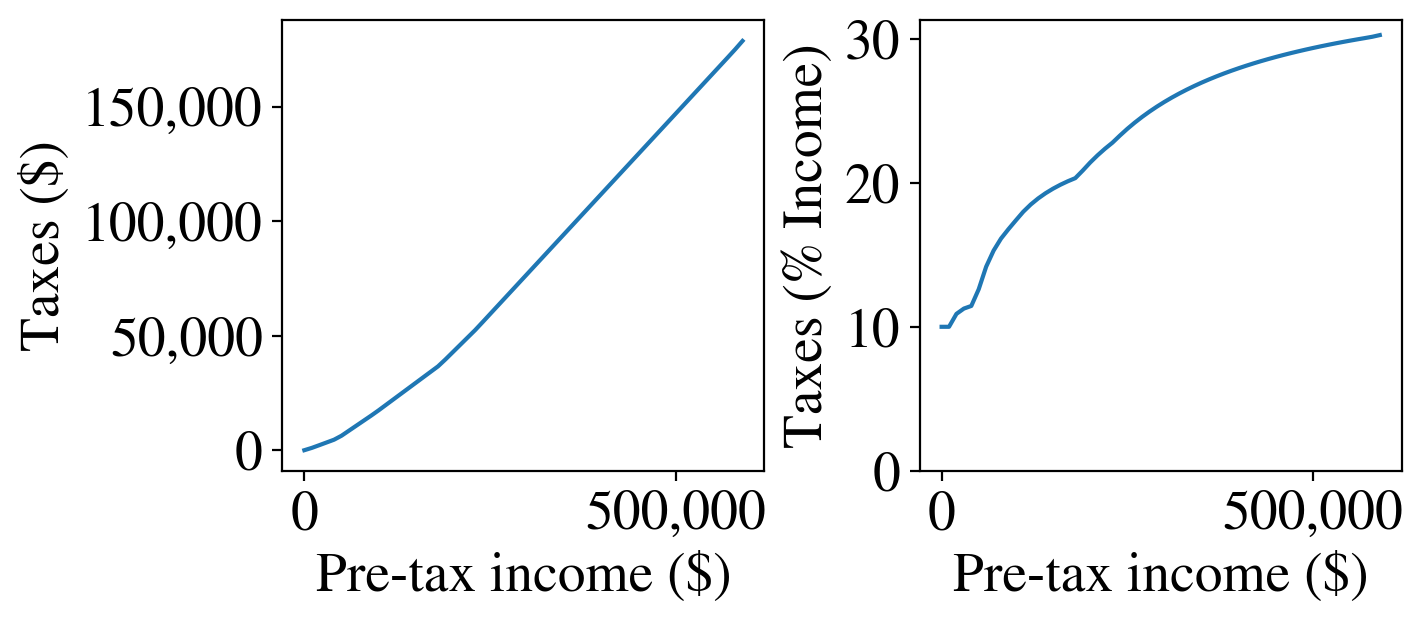

In [58]:
fig, axs = plt.subplots(figsize=(7,3), ncols=2, constrained_layout=True)

x = np.arange(1, 600_000, 10_000)

ax = axs[0]
y = np.array([tax(i, 0, 2023) for i in x])

ax.plot(x, y)#y/x*100)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**{
    "xlabel": "Pre-tax income ($)",
    "ylabel": "Taxes ($)"
})

ax = axs[1]
y = y/x*100

ax.plot(x, y)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**{
    "xlabel": "Pre-tax income ($)",
    "ylabel": "Taxes (% Income)",
    "ylim": 0
})

fig.show()

## Download data

In [59]:
# Download plan numbers
!curl -Ls https://raw.githubusercontent.com/sbooeshaghi/health-insurance/main/caltech-health_plans.json > caltech-health_plans.json

In [60]:
with open("caltech-health_plans.json", "r") as f:
  plans = json.load(f)

In [61]:
# Add tax deductible normalization for comparing the PPO plans for '22, '23, and '24
plans["PPO2800-22"]["norm"] = 0
plans["PPO1600-22"]["norm"] = tax(income, plans["PPO2800-22"]["premium"], year=2021) - tax(income, plans["PPO1600-22"]["premium"], year=2021)

plans["PPO3000-23"]["norm"] = 0
plans["PPO1800-23"]["norm"] = tax(income, plans["PPO3000-23"]["premium"], year=2022) - tax(income, plans["PPO1800-23"]["premium"], year=2022)

plans["PPO3200-24"]["norm"] = 0
plans["PPO1800-24"]["norm"] = tax(income, plans["PPO3200-24"]["premium"], year=2023) - tax(income, plans["PPO1800-24"]["premium"], year=2023)

In [62]:
# This analysis will be done possible medical expenditures from $0 to $30,000
x = np.arange(0, 20_000)

# 2022 Plan comparison

156.00 1,116.00
-89.52 870.48


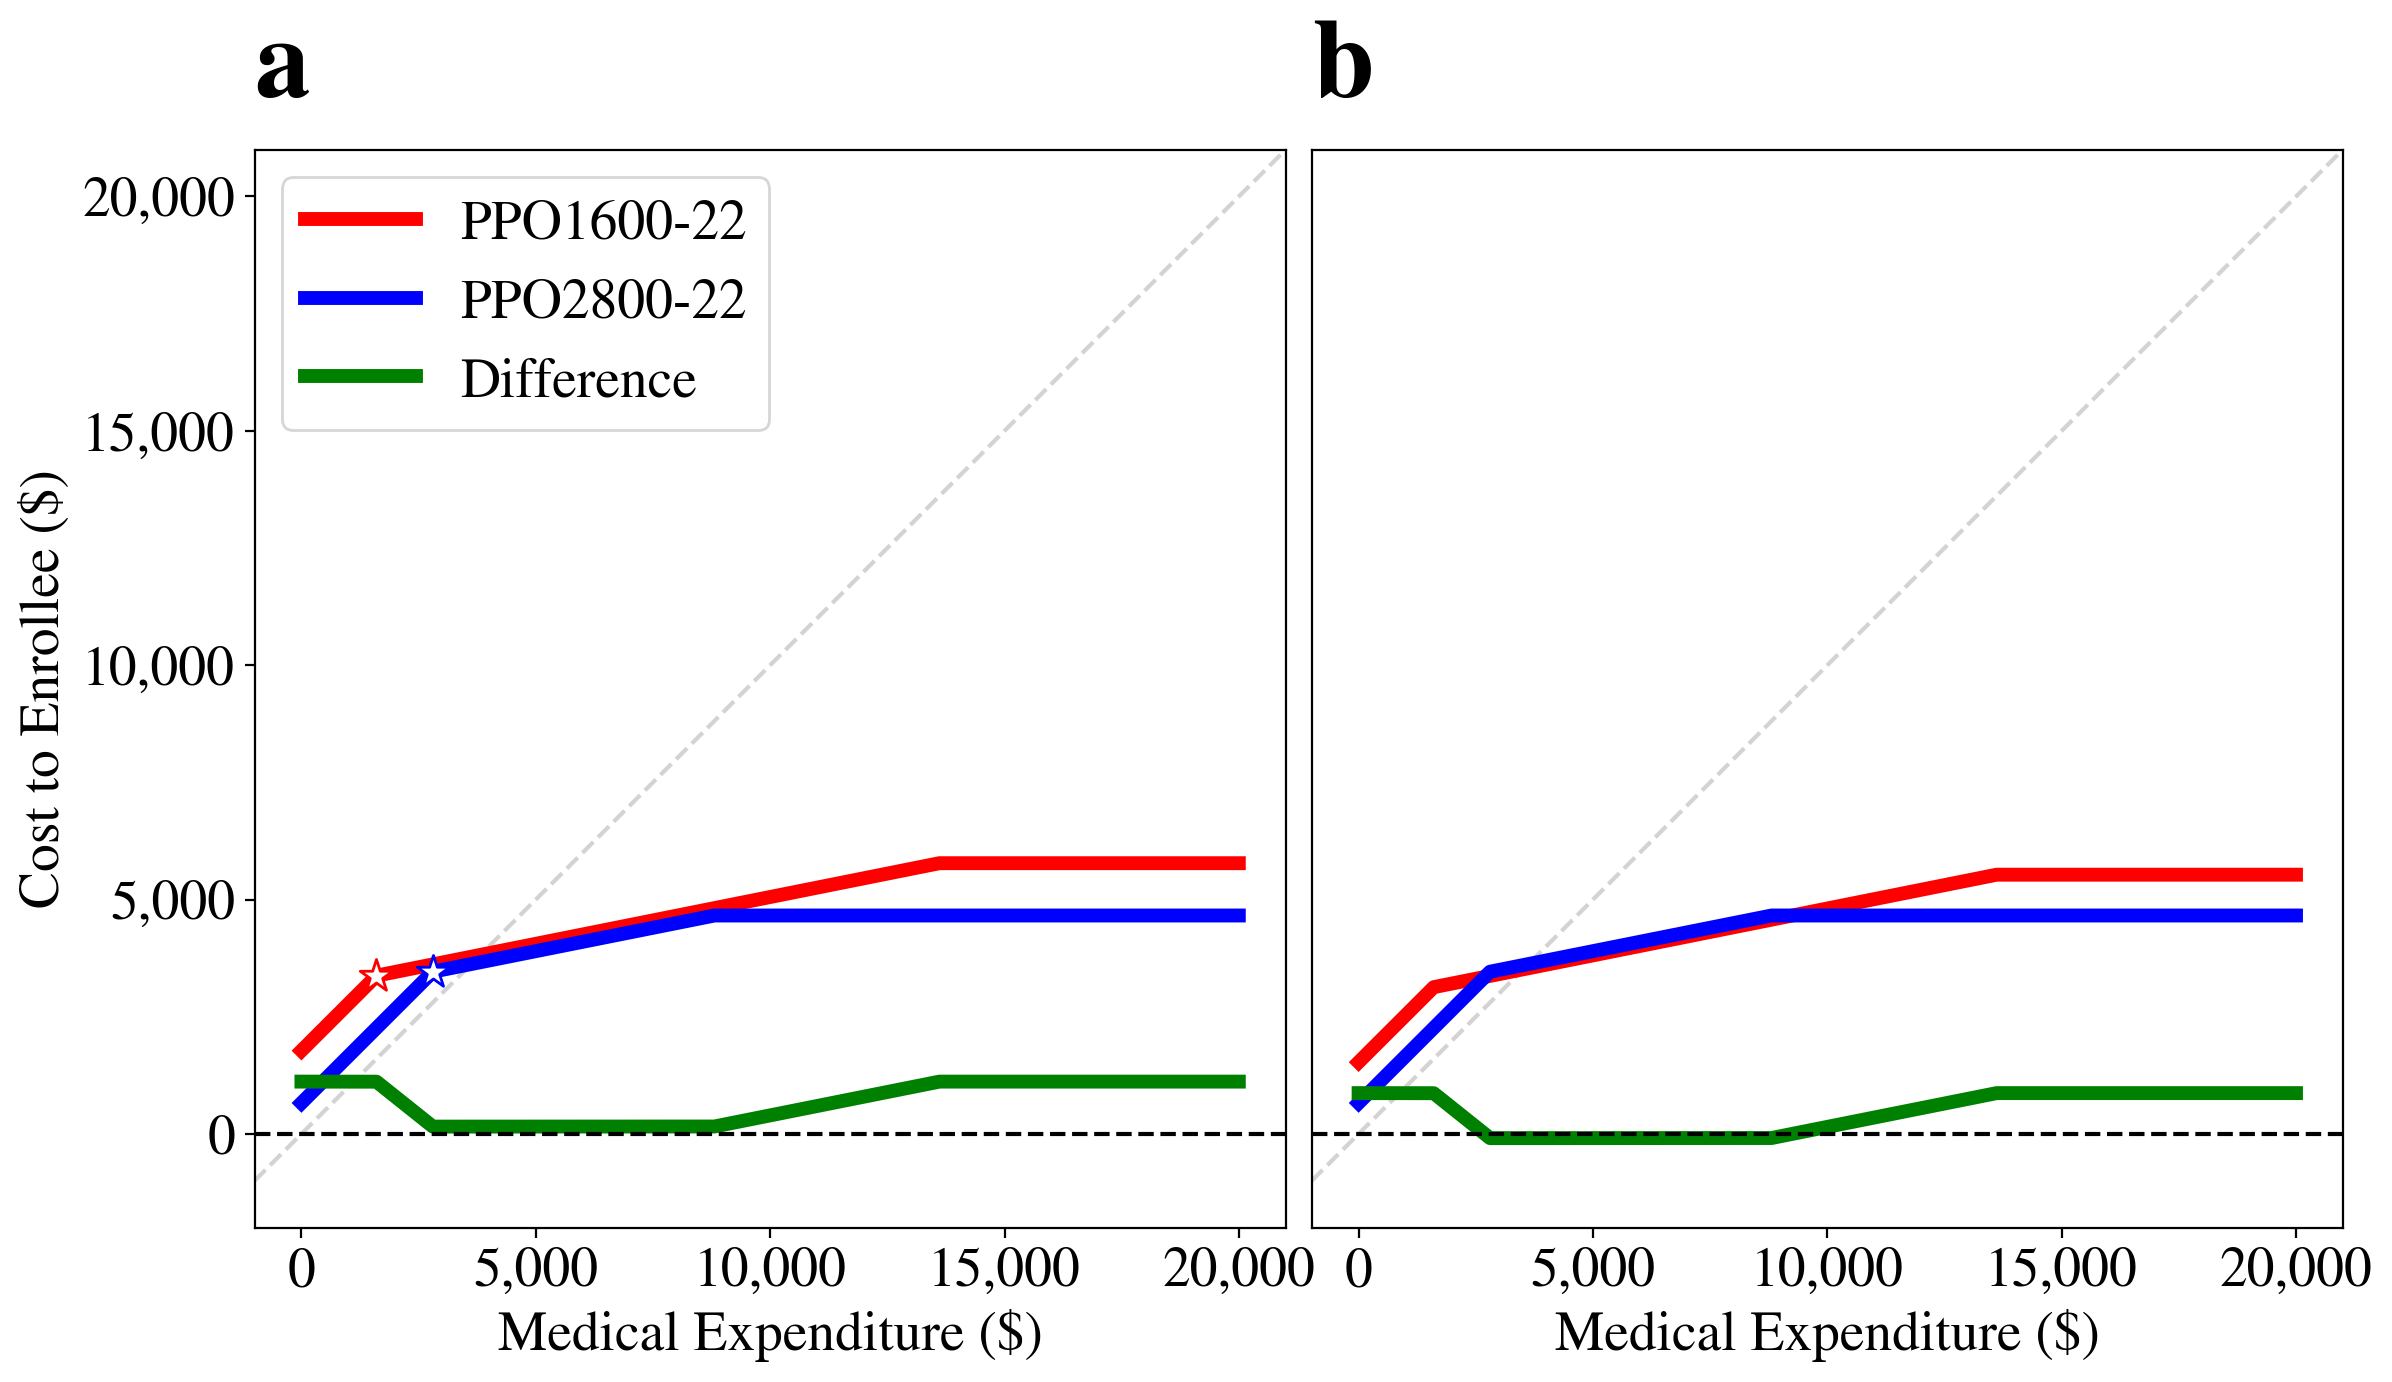

In [63]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=-0.05)

##################################### First plan
plan = "PPO1600-22"
color = "red"

premium, deductible, oopm, norm = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan, color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)

p1_nn = y0
p1_norm = y1

##################################### Second plan
plan = "PPO2800-22"
color = "blue"

premium, deductible, oopm, norm = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan, color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)

##################################### Plot differences
p2_nn = y0
p2_norm = y1

axs[0].plot(x, p1_nn-p2_nn, color="green", label="Difference", linewidth=5) # Diff in price
axs[1].plot(x, p1_norm-p2_norm, color="green", label="Difference", linewidth=5) # Diff in price


### Plot settings
for ax in axs:
  ax.axhline(y=0, color="black", linestyle="--")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


##################################### plot settings

axs[0].set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee ($)",
    "ylim": -2000
})
axs[1].set(**{
    "xlabel": "Medical Expenditure ($)",
    "yticks": [],
    "yticklabels": [],
    "ylim": -2000
})

axs[0].legend()

for n, ax in enumerate(axs.flat):
    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes,
            size=40, weight='bold')

fig.savefig("plan_comparison-22.png", dpi=300, bbox_inches="tight")
fig.show()

print(f"{min(p1_nn-p2_nn):,.2f}", f"{max(p1_nn-p2_nn):,.2f}")
print(f"{min(p1_norm-p2_norm):,.2f}", f"{max(p1_norm-p2_norm):,.2f}")

In [66]:
print(x[np.where(p1_norm-p2_norm < 0)[0][0]]) # low end intersect
print(x[np.where(p1_norm-p2_norm < 0)[0][-1]]) # high end intersect

# how much are you saving in taxes with a higher premium?
print(tax(income, plans["PPO2800-22"]["premium"], 2021) - tax(income, plans["PPO1600-22"]["premium"], 2021))

2689
9247
245.52000000000044


In [67]:
tax(64_480, 0, 2021), tax(64_480, 1_000, 2021), (tax(64_480, 0, 2021) - tax(64_480, 1_000, 2021))

(9933.759999999998, 9713.759999999998, 220.0)

### 2022 Total premium cost

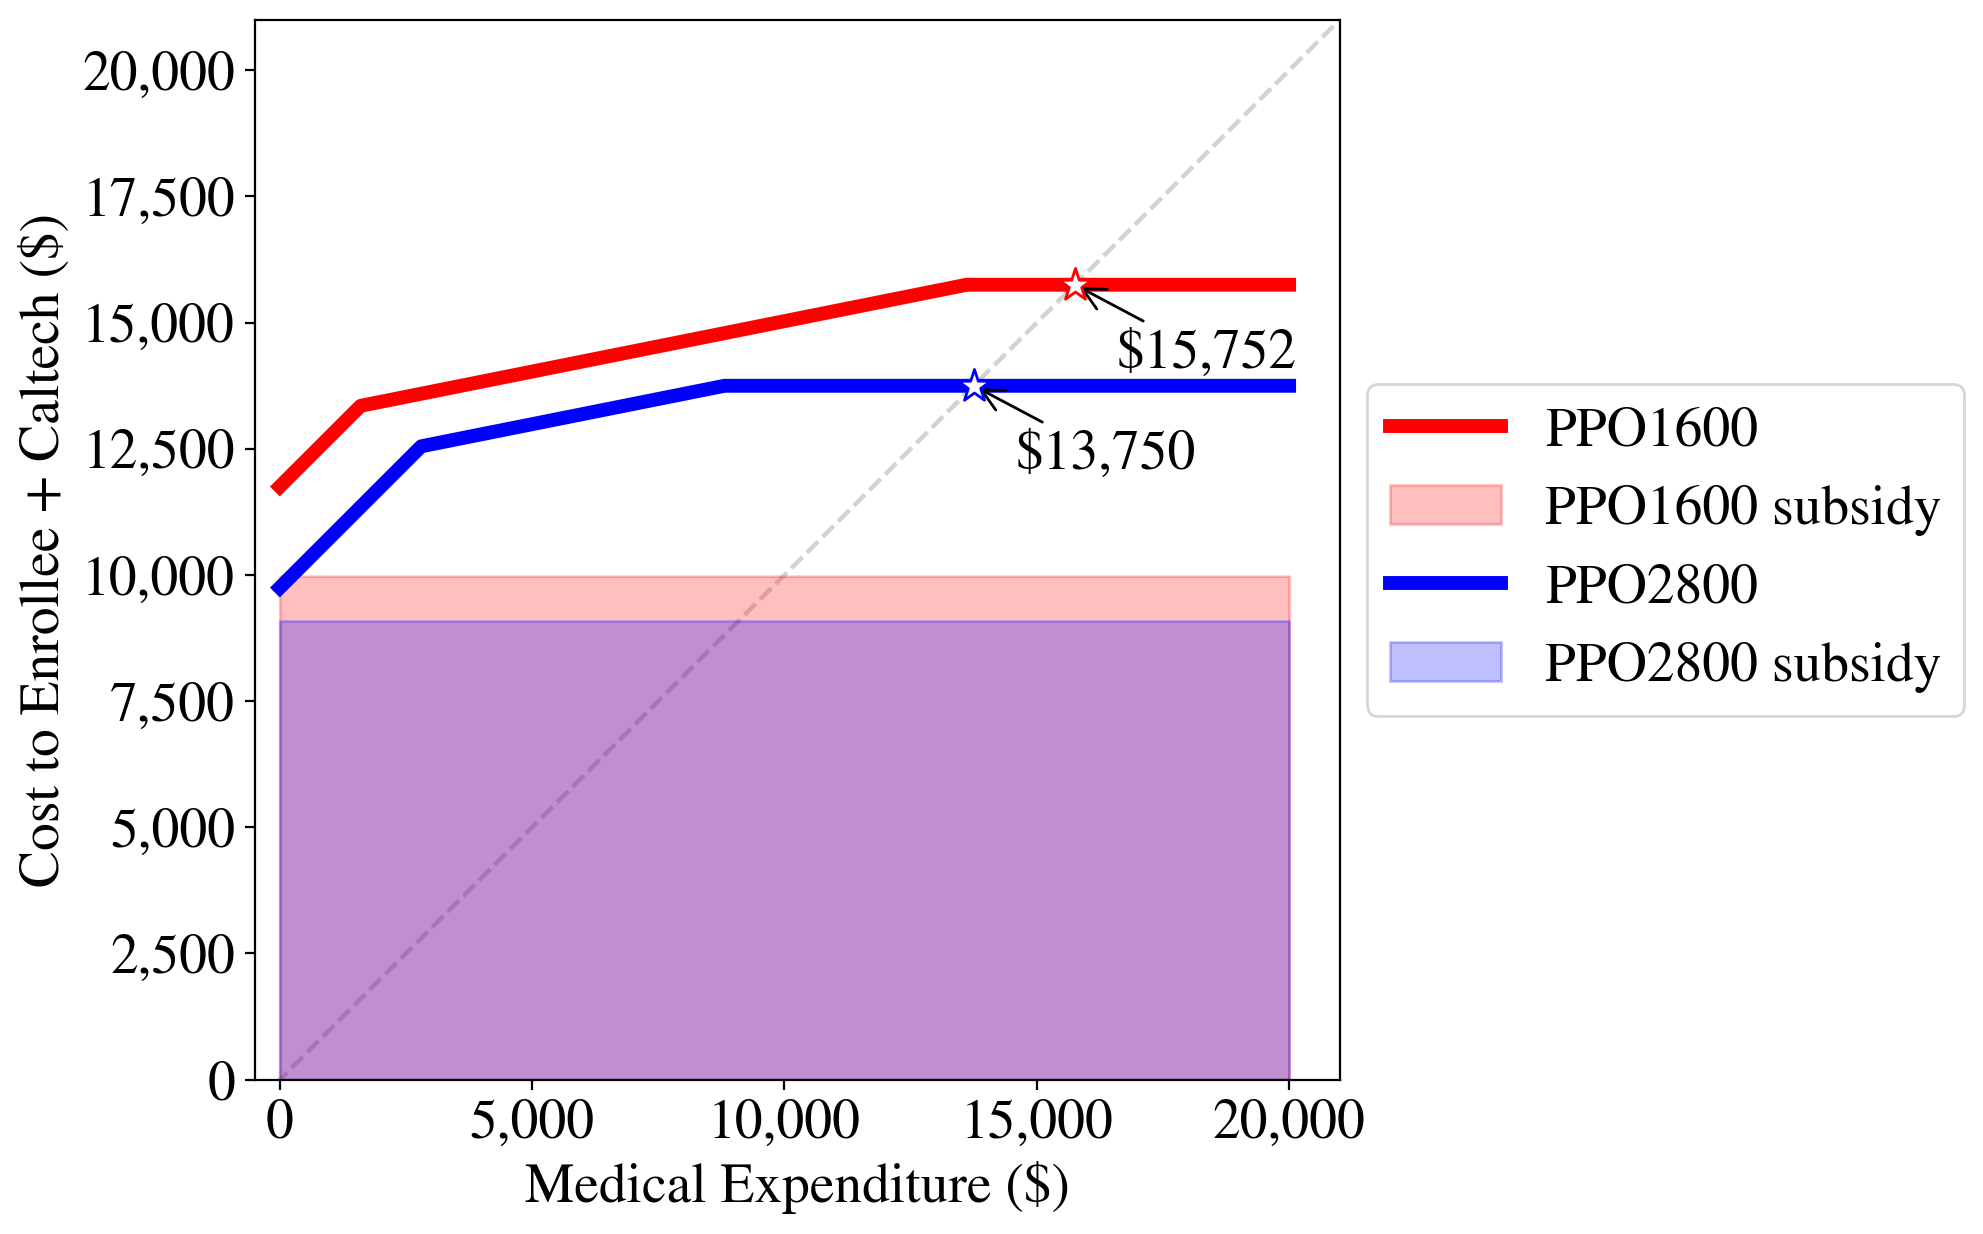

In [68]:
fig, ax = plt.subplots(figsize=(7,7))
fig.subplots_adjust(hspace=0, wspace=0.05)

## First plan
plan="PPO1600-22"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "red"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, color=color, linewidth=5, label=plan.split("-")[0])
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )
# # Difference

ax.fill_between(x, len(x)*[0], len(x)*[sub], color=color, alpha=0.25, label=f"{plan.split('-')[0]} subsidy")

yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))




##### Second Plan
plan="PPO2800-22"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "blue"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan.split("-")[0], color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )

# # Difference

ax.fill_between(x, len(x)*[0], len(x)*[sub], color=color, alpha=0.25, label=f"{plan.split('-')[0]} subsidy")

yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee + Caltech ($)",
    "ylim": 0,
    "xlim": -500
})


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig("breakeven-22.png", dpi=300, bbox_inches="tight")
fig.show()

# 2022 Income assesment

#### Without normalization

In [71]:
# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets21.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO2800-22"]["premium"], 2021) - tax(inc, plans["PPO1600-22"]["premium"], 2021)
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1600-22"]["premium"]     , plans["PPO1600-22"]["deductible"], plans["PPO1600-22"]["oopm"])
    c2 = insurance_cost(i, plans["PPO2800-22"]["premium"]     , plans["PPO2800-22"]["deductible"], plans["PPO2800-22"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

In [72]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets21.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)

,min_savings,max_savings
"(0, 9950)",156.0,1116.0
"(9951, 40525)",156.0,1116.0
"(40526, 86375)",156.0,1116.0
"(86376, 164925)",156.0,1116.0
"(164926, 209425)",156.0,1116.0
"(209426, 523600)",156.0,1116.0
"(523601, 9999999)",156.0,1116.0


#### With normalization

In [73]:
# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets21.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO2800-22"]["premium"], 2021) - tax(inc, plans["PPO1600-22"]["premium"], 2021)
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1600-22"]["premium"]-norm, plans["PPO1600-22"]["deductible"], plans["PPO1600-22"]["oopm"])
    c2 = insurance_cost(i, plans["PPO2800-22"]["premium"]     , plans["PPO2800-22"]["deductible"], plans["PPO2800-22"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

In [74]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets21.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)

,min_savings,max_savings
"(0, 9950)",62.264444,1022.264444
"(9951, 40525)",24.312000,984.312000
"(40526, 86375)",-78.360000,881.640000
"(86376, 164925)",-109.608000,850.392000
"(164926, 209425)",-192.192000,767.808000
"(209426, 523600)",-231.252000,728.748000
"(523601, 9999999)",-254.688000,705.312000


# 2023 Plan comparison

In [75]:
x = np.arange(0, 20_000)

252.00 1,212.00
-14.64 945.36


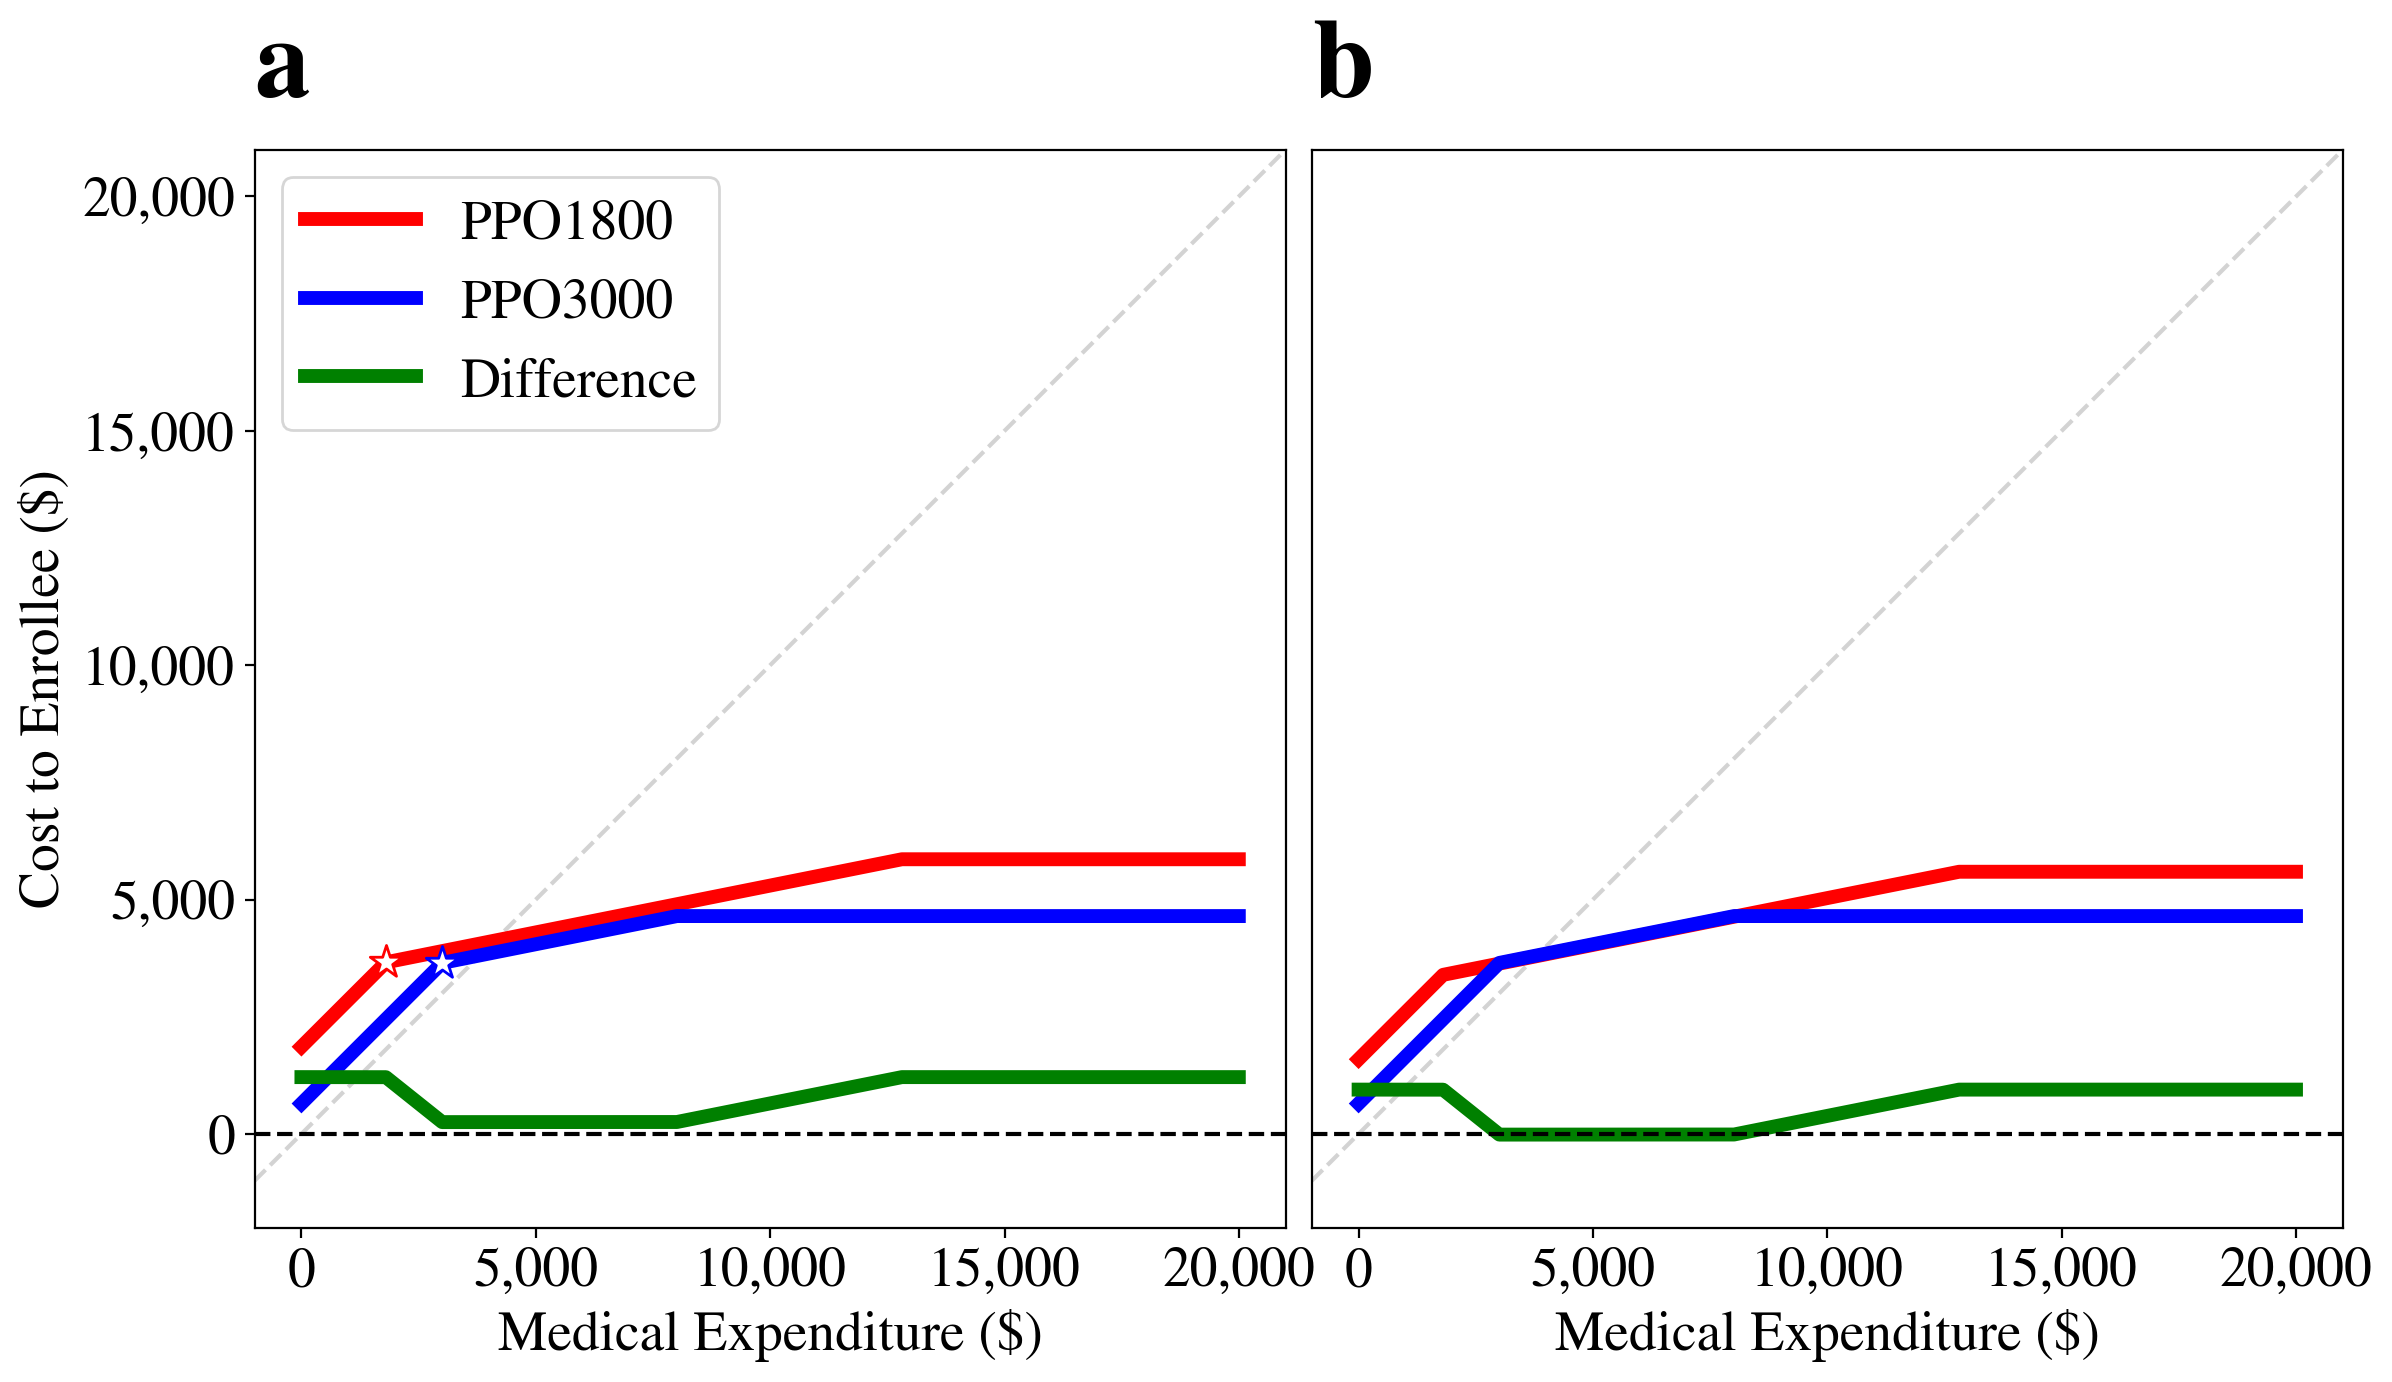

In [76]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=-0.05)

##################################### First plan
plan = "PPO1800-23"
color = "red"

premium, deductible, oopm, norm = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan.split("-")[0], color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan.split("-")[0], color=color, linewidth=5)

p1_nn = y0
p1_norm = y1

##################################### Second plan
plan = "PPO3000-23"
color = "blue"

premium, deductible, oopm, norm = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan.split("-")[0], color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)

##################################### Plot differences
p2_nn = y0
p2_norm = y1

axs[0].plot(x, p1_nn-p2_nn, color="green", label="Difference", linewidth=5) # Diff in price
axs[1].plot(x, p1_norm-p2_norm, color="green", label="Difference", linewidth=5) # Diff in price


### Plot settings
for ax in axs:
  ax.axhline(y=0, color="black", linestyle="--")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


##################################### plot settings

axs[0].set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee ($)",
    "ylim": -2000
})
axs[1].set(**{
    "xlabel": "Medical Expenditure ($)",
    "yticks": [],
    "yticklabels": [],
    "ylim": -2000
})

axs[0].legend()

for n, ax in enumerate(axs.flat):
    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes,
            size=40, weight='bold')

fig.savefig("plan_comparison-23.png", dpi=300, bbox_inches="tight")
fig.show()

print(f"{min(p1_nn-p2_nn):,.2f}", f"{max(p1_nn-p2_nn):,.2f}")
print(f"{min(p1_norm-p2_norm):,.2f}", f"{max(p1_norm-p2_norm):,.2f}")

In [77]:
print(x[np.where(p1_norm-p2_norm < 0)[0][0]]) # low end intersect
print(x[np.where(p1_norm-p2_norm < 0)[0][-1]]) # high end intersect

# how much are you saving in taxes with a higher premium?
print(tax(income, plans["PPO3000-23"]["premium"], 2022) - tax(income, plans["PPO1800-23"]["premium"], 2022))

2982
8073
266.6399999999994


### 2023 Total premium cost

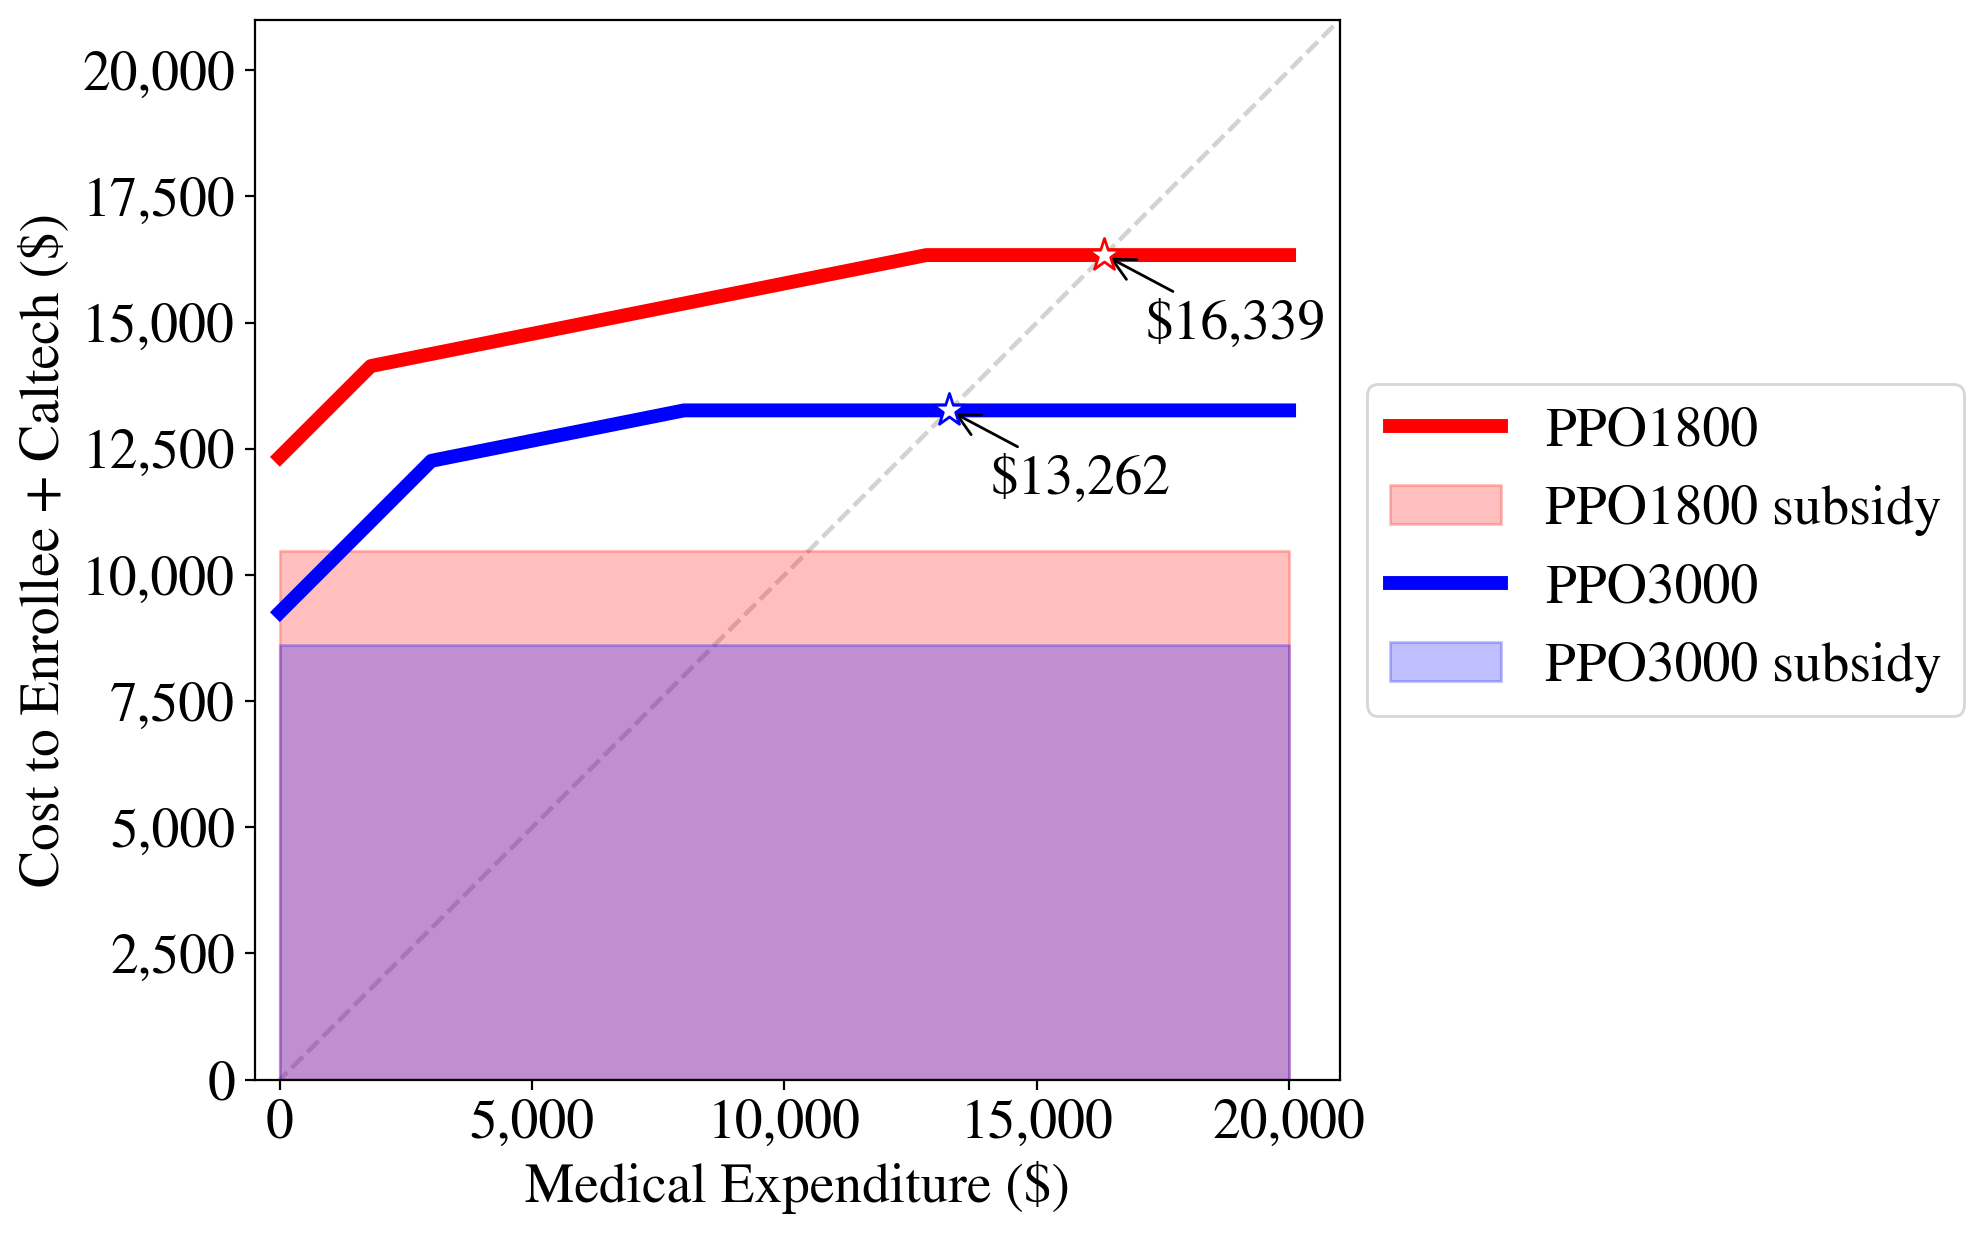

In [78]:
fig, ax = plt.subplots(figsize=(7,7))
fig.subplots_adjust(hspace=0, wspace=0.05)

## First plan
plan="PPO1800-23"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "red"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, color=color, linewidth=5, label=plan.split("-")[0])
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )
# # Difference

ax.fill_between(x, len(x)*[0], len(x)*[sub], color=color, alpha=0.25, label=f"{plan.split('-')[0]} subsidy")

yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))




##### Second Plan
plan="PPO3000-23"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "blue"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan.split("-")[0], color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )

# # Difference

ax.fill_between(x, len(x)*[0], len(x)*[sub], color=color, alpha=0.25, label=f"{plan.split('-')[0]} subsidy")

yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee + Caltech ($)",
    "ylim": 0,
    "xlim": -500
})


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig("breakeven-23.png", dpi=300, bbox_inches="tight")
fig.show()

At what medical expenditure do we hit the out of pocket maximum?

In [79]:
plan="PPO1800-23"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
x[np.where((oopm + premium - y1 < 0.01))[0][0]]

12800

In [80]:
plan="PPO3000-23"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
x[np.where((oopm + premium - y1 < 0.01))[0][0]]

8000

# 2023 Income assesement

#### Without normalization

In [81]:
# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets22.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO3000-23"]["premium"], 2022) - tax(inc, plans["PPO1800-23"]["premium"], 2022)
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1800-23"]["premium"]    , plans["PPO1800-23"]["deductible"], plans["PPO1800-23"]["oopm"])
    c2 = insurance_cost(i, plans["PPO3000-23"]["premium"]     , plans["PPO3000-23"]["deductible"], plans["PPO3000-23"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

In [82]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets22.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)

,min_savings,max_savings
"(0, 10275)",252.0,1212.0
"(10276, 41775)",252.0,1212.0
"(41776, 89075)",252.0,1212.0
"(89076, 170050)",252.0,1212.0
"(170051, 215950)",252.0,1212.0
"(215951, 539900)",252.0,1212.0
"(539901, 9999999)",252.0,1212.0


#### With normalization

In [83]:
# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets22.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO3000-23"]["premium"], 2022) - tax(inc, plans["PPO1800-23"]["premium"], 2022)
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1800-23"]["premium"]-norm, plans["PPO1800-23"]["deductible"], plans["PPO1800-23"]["oopm"])
    c2 = insurance_cost(i, plans["PPO3000-23"]["premium"]     , plans["PPO3000-23"]["deductible"], plans["PPO3000-23"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

In [84]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets22.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)

,min_savings,max_savings
"(0, 10275)",150.103333,1110.103333
"(10276, 41775)",108.984000,1068.984000
"(41776, 89075)",-2.520000,957.480000
"(89076, 170050)",-36.456000,923.544000
"(170051, 215950)",-126.144000,833.856000
"(215951, 539900)",-168.564000,791.436000
"(539901, 9999999)",-194.016000,765.984000


# 2024 comparison

In [85]:
x = np.arange(0, 20_000)

152.00 1,272.00
-127.84 992.16


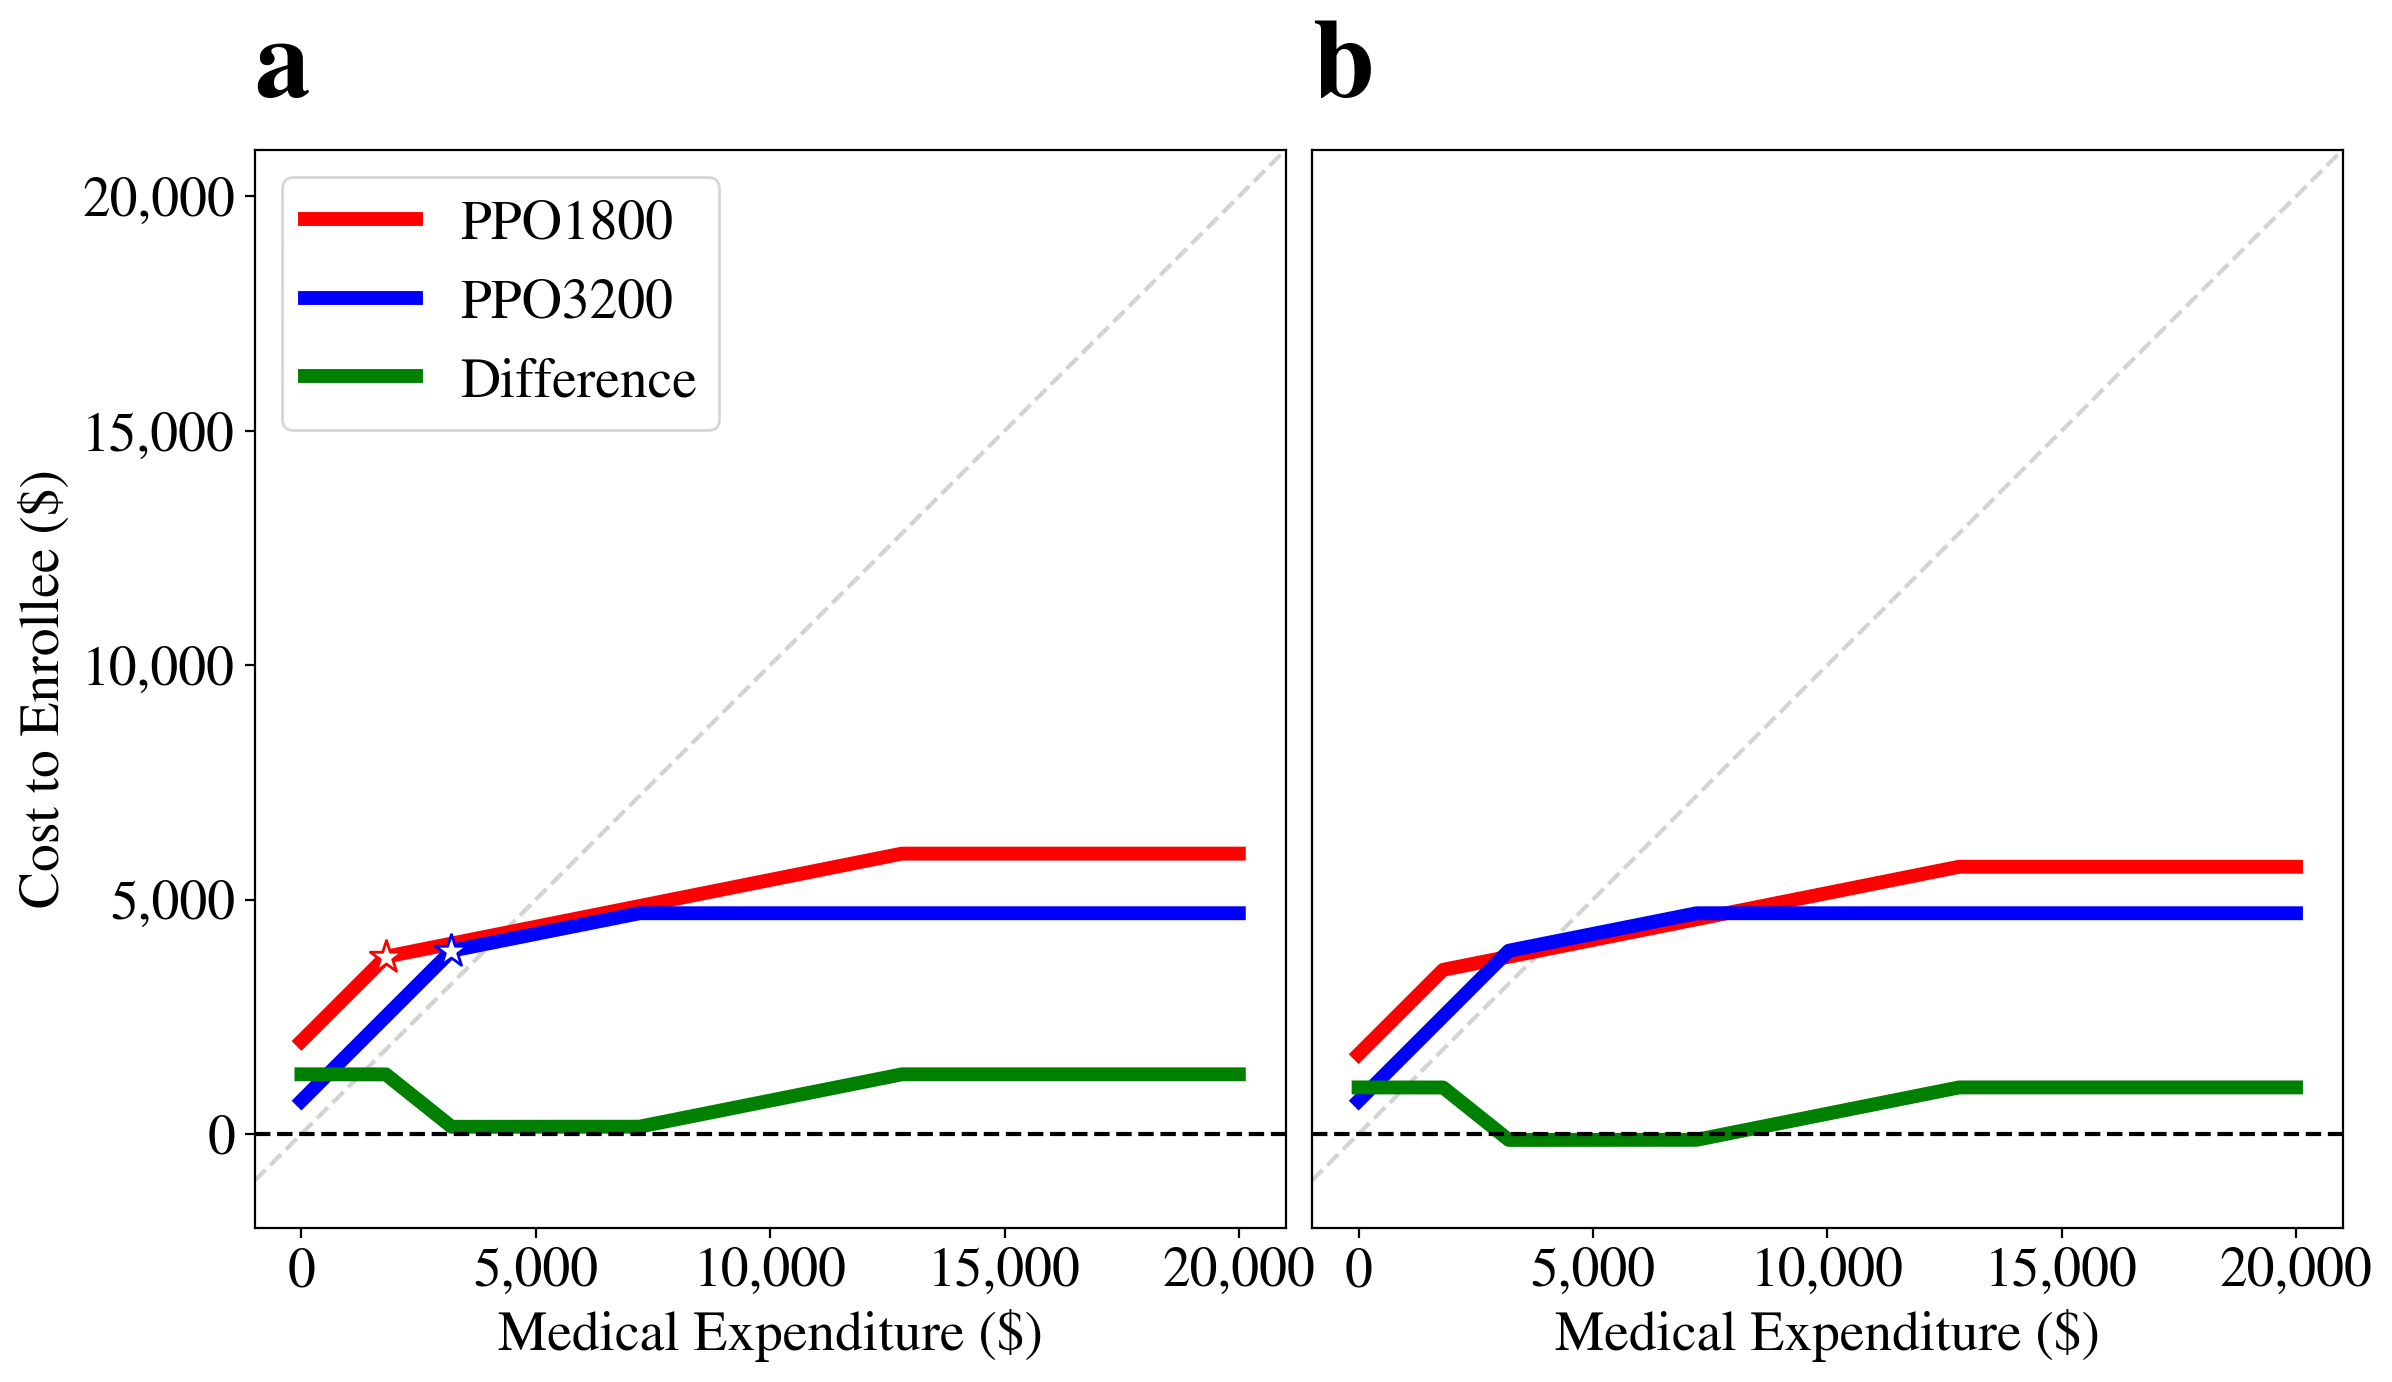

In [86]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=-0.05)

##################################### First plan
plan = "PPO1800-24"
color = "red"

premium, deductible, oopm, norm = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan.split("-")[0], color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan.split("-")[0], color=color, linewidth=5)

p1_nn = y0
p1_norm = y1

##################################### Second plan
plan = "PPO3200-24"
color = "blue"

premium, deductible, oopm, norm = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan.split("-")[0], color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)

##################################### Plot differences
p2_nn = y0
p2_norm = y1

axs[0].plot(x, p1_nn-p2_nn, color="green", label="Difference", linewidth=5) # Diff in price
axs[1].plot(x, p1_norm-p2_norm, color="green", label="Difference", linewidth=5) # Diff in price


### Plot settings
for ax in axs:
  ax.axhline(y=0, color="black", linestyle="--")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


##################################### plot settings

axs[0].set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee ($)",
    "ylim": -2000
})
axs[1].set(**{
    "xlabel": "Medical Expenditure ($)",
    "yticks": [],
    "yticklabels": [],
    "ylim": -2000
})

axs[0].legend()

for n, ax in enumerate(axs.flat):
    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes,
            size=40, weight='bold')

fig.savefig("plan_comparison-24.png", dpi=300, bbox_inches="tight")
fig.show()

print(f"{min(p1_nn-p2_nn):,.2f}", f"{max(p1_nn-p2_nn):,.2f}")
print(f"{min(p1_norm-p2_norm):,.2f}", f"{max(p1_norm-p2_norm):,.2f}")


In [87]:
print(x[np.where(p1_norm-p2_norm < 0)[0][0]]) # low end intersect
print(x[np.where(p1_norm-p2_norm < 0)[0][-1]]) # high end intersect

# how much are you saving in taxes with a higher premium?
print(tax(income, plans["PPO3200-24"]["premium"], 2023) - tax(income, plans["PPO1800-24"]["premium"], 2023))


3041
7839
279.84000000000015


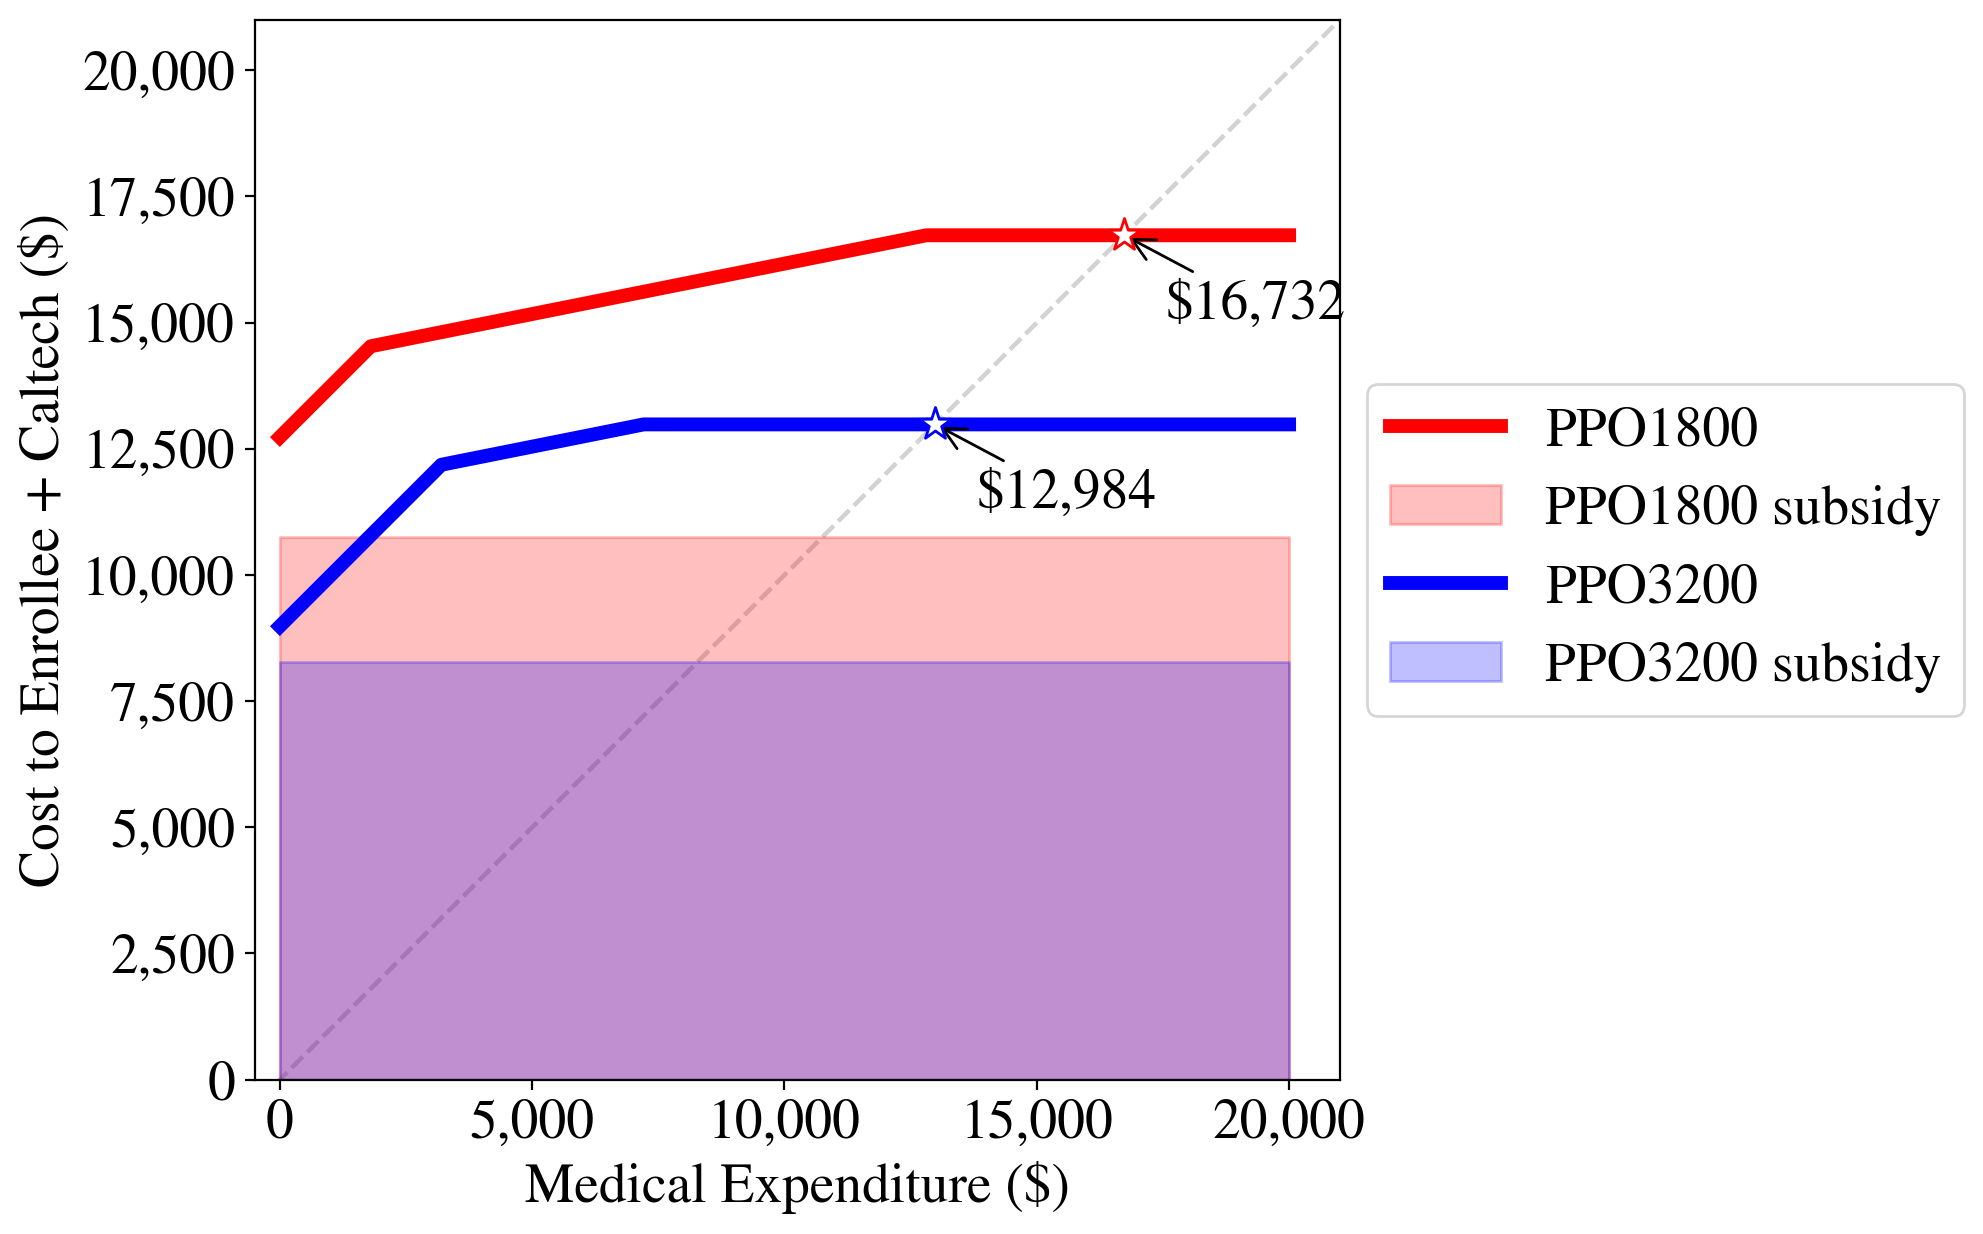

In [88]:
fig, ax = plt.subplots(figsize=(7,7))
fig.subplots_adjust(hspace=0, wspace=0.05)

## First plan
plan="PPO1800-24"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "red"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, color=color, linewidth=5, label=plan.split("-")[0])
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )
# # Difference

ax.fill_between(x, len(x)*[0], len(x)*[sub], color=color, alpha=0.25, label=f"{plan.split('-')[0]} subsidy")

yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))




##### Second Plan
plan="PPO3200-24"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "blue"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan.split("-")[0], color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )

# # Difference

ax.fill_between(x, len(x)*[0], len(x)*[sub], color=color, alpha=0.25, label=f"{plan.split('-')[0]} subsidy")

yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee + Caltech ($)",
    "ylim": 0,
    "xlim": -500
})


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig("breakeven-24.png", dpi=300, bbox_inches="tight")
fig.show()


In [89]:
# medical expenditure where we hit the out of pocket maximum

plan="PPO1800-24"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
x[np.where((oopm + premium - y1 < 0.01))[0][0]]

12800

In [90]:
plan="PPO3200-24"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"],
    plans[plan]["deductible"],
    plans[plan]["oopm"],
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
x[np.where((oopm + premium - y1 < 0.01))[0][0]]

7200

In [91]:
## 2024 Income Assessment

#### Without normalization

In [92]:

# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets23.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO3200-24"]["premium"], 2023) - tax(inc, plans["PPO1800-24"]["premium"], 2023)
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1800-24"]["premium"]    , plans["PPO1800-24"]["deductible"], plans["PPO1800-24"]["oopm"])
    c2 = insurance_cost(i, plans["PPO3200-24"]["premium"]     , plans["PPO3200-24"]["deductible"], plans["PPO3200-24"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

In [93]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets23.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)


,min_savings,max_savings
"(0, 11000)",152.0,1272.0
"(11001, 44725)",152.0,1272.0
"(44726, 95375)",152.0,1272.0
"(95376, 182100)",152.0,1272.0
"(182101, 231250)",152.0,1272.0
"(231251, 578125)",152.0,1272.0
"(578126, 9999999)",152.0,1272.0


#### With normalization

In [94]:
# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets23.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO3200-24"]["premium"], 2023) - tax(inc, plans["PPO1800-24"]["premium"], 2023)
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1800-24"]["premium"]-norm, plans["PPO1800-24"]["deductible"], plans["PPO1800-24"]["oopm"])
    c2 = insurance_cost(i, plans["PPO3200-24"]["premium"]     , plans["PPO3200-24"]["deductible"], plans["PPO3200-24"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2


In [95]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets23.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)


,min_savings,max_savings
"(0, 11000)",45.097778,1165.097778
"(11001, 44725)",1.904000,1121.904000
"(44726, 95375)",-115.120000,1004.880000
"(95376, 182100)",-150.736000,969.264000
"(182101, 231250)",-244.864000,875.136000
"(231251, 578125)",-289.384000,830.616000
"(578126, 9999999)",-316.096000,803.904000


# Year over year comparison

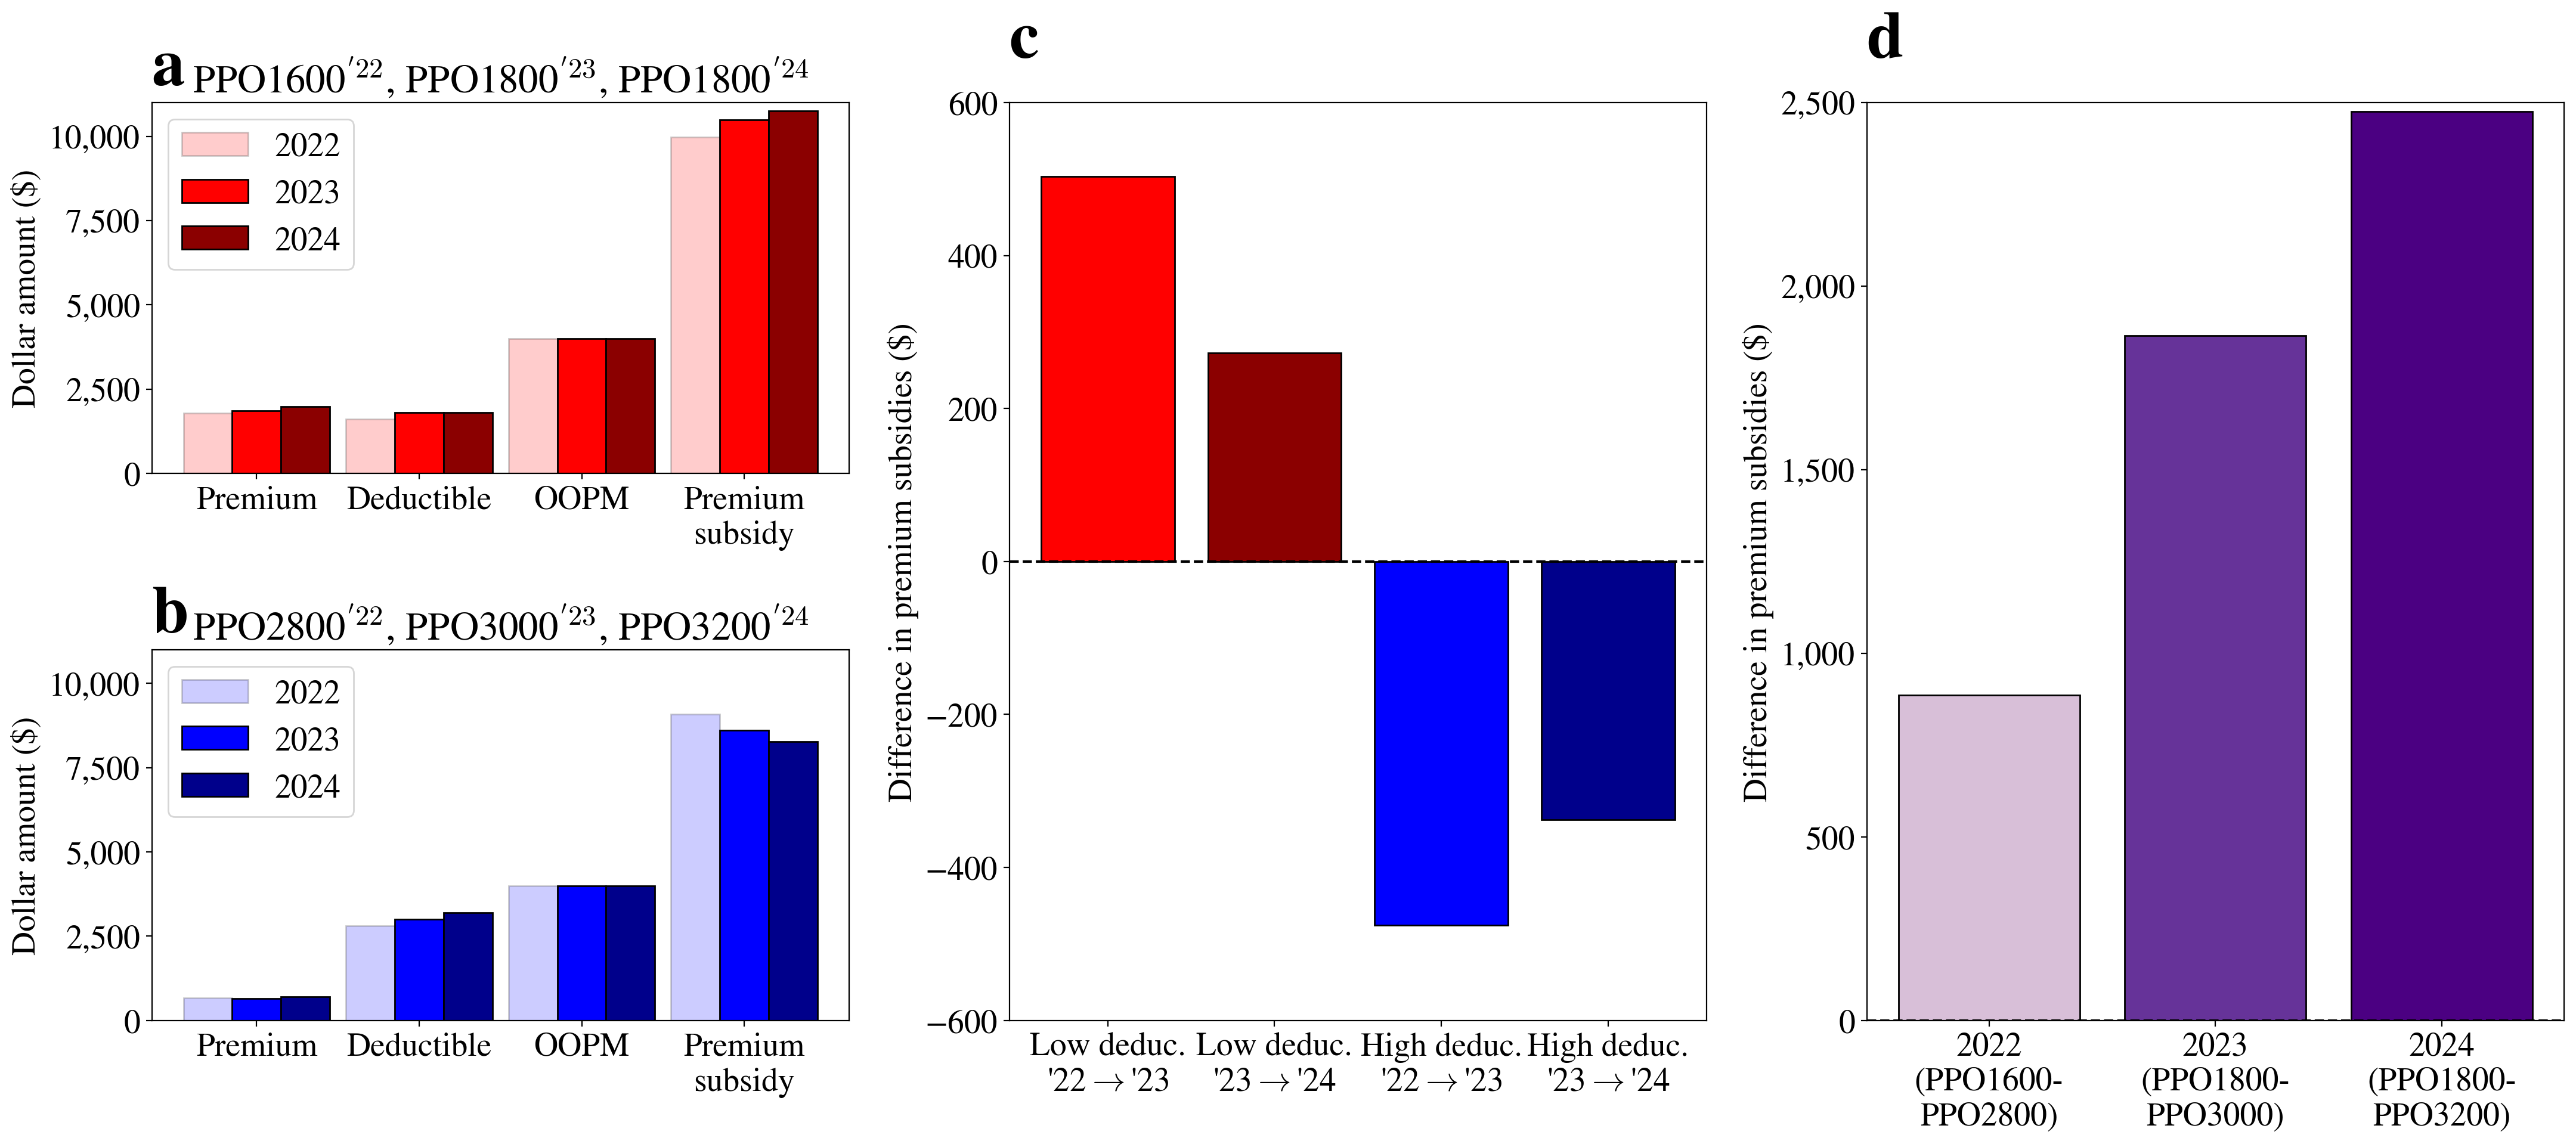

In [96]:
fig = plt.figure(tight_layout=True, figsize=(22,10))
gs = gridspec.GridSpec(2, 3)

axs = [fig.add_subplot(gs[0, 0]),
       fig.add_subplot(gs[1, 0]),
       fig.add_subplot(gs[:, 1]),
       fig.add_subplot(gs[:, 2])]

fig.subplots_adjust(hspace=0, wspace=0)

######################################################################################################################################################
ax = axs[0]
plan22 = "PPO1600-22"
premium22, deductible22, oopm22, sub22 = (
    plans[plan22]["premium"],
    plans[plan22]["deductible"],
    plans[plan22]["oopm"],
    plans[plan22]["premium_subsidy"]
)

y22 = [
    premium22, deductible22, oopm22, sub22
]

plan23 = "PPO1800-23"
premium23, deductible23, oopm23, sub23 = (
    plans[plan23]["premium"],
    plans[plan23]["deductible"],
    plans[plan23]["oopm"],
    plans[plan23]["premium_subsidy"]
)
y23 = [
    premium23, deductible23, oopm23, sub23
]

plan24 = "PPO1800-24"
premium24, deductible24, oopm24, sub24 = (
    plans[plan24]["premium"],
    plans[plan24]["deductible"],
    plans[plan24]["oopm"],
    plans[plan24]["premium_subsidy"]
)
y24 = [
    premium24, deductible24, oopm24, sub24
]

labels = ["Premium", "Deductible", "OOPM", "Premium\nsubsidy"]
x = np.arange(len(labels))
width = 0.3

ax.bar(x-width, y22, width=width, label='2022', edgecolor="k", color="red", alpha=0.2)
ax.bar(x, y23, width=width, label='2023', edgecolor="k", color="red")
ax.bar(x+width, y24, width=width, label='2024', edgecolor="k", color="darkred") # New year's data


ax.set(**{
    "xticks": x,
    "xticklabels": labels,
    "title": f"{plan22.split('-')[0]}$^{{'22}}$, {plan23.split('-')[0]}$^{{'23}}$, {plan24.split('-')[0]}$^{{'24}}$",
    "ylim": (0, 11_000),
    "ylabel": "Dollar amount ($)"
    }
)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

##################################################################################
ax = axs[1]

plan22 = "PPO2800-22"
premium22, deductible22, oopm22, sub22 = (
    plans[plan22]["premium"],
    plans[plan22]["deductible"],
    plans[plan22]["oopm"],
    plans[plan22]["premium_subsidy"]
)

y22 = [
    premium22, deductible22, oopm22, sub22
]

plan23 = "PPO3000-23"
premium23, deductible23, oopm23, sub23 = (
    plans[plan23]["premium"],
    plans[plan23]["deductible"],
    plans[plan23]["oopm"],
    plans[plan23]["premium_subsidy"]
)
y23 = [
    premium23, deductible23, oopm23, sub23
]

plan24 = "PPO3200-24"
premium24, deductible24, oopm24, sub24 = (
    plans[plan24]["premium"],
    plans[plan24]["deductible"],
    plans[plan24]["oopm"],
    plans[plan24]["premium_subsidy"]
)
y24 = [
    premium24, deductible24, oopm24, sub24
]

labels = ["Premium", "Deductible", "OOPM", "Premium\nsubsidy"]
x = np.arange(len(labels))
width = 0.3
ax.bar(x-width, y22, width=width, label='2022', edgecolor="k", color="blue", alpha=0.2)
ax.bar(x, y23, width=width, label='2023', edgecolor="k", color="blue")
ax.bar(x+width, y24, width=width, label='2024', edgecolor="k", color="darkblue") # New year's data


ax.set(**{
    "xticks": x,
    "xticklabels": labels,
    "ylim": (0, 11_000),
    "ylabel": "Dollar amount ($)",
    "title": f"{plan22.split('-')[0]}$^{{'22}}$, {plan23.split('-')[0]}$^{{'23}}$, {plan24.split('-')[0]}$^{{'24}}$",
    }
)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

ax = axs[2]
# labels = [
#     "PPO1600 (2022)\n" + r"$\rightarrow$ PPO1800 (2023)",
#     "PPO1800 (2023)\n" + r"$\rightarrow$ PPO1800 (2024)",
#     "PPO2800 (2022)\n" + r"$\rightarrow$ PPO3000 (2023)",
#     "PPO3000 (2023)\n" + r"$\rightarrow$ PPO3200 (2024)"
# ]
labels = [
    "Low deduc.\n'22" + r"$\rightarrow$'23",
    "Low deduc.\n'23" + r"$\rightarrow$'24",
    "High deduc.\n'22" + r"$\rightarrow$'23",
    "High deduc.\n'23" + r"$\rightarrow$'24"
]
y = [
    plans["PPO1800-23"]["premium_subsidy"] - plans["PPO1600-22"]["premium_subsidy"],
    plans["PPO1800-24"]["premium_subsidy"] - plans["PPO1800-23"]["premium_subsidy"],
    plans["PPO3000-23"]["premium_subsidy"] - plans["PPO2800-22"]["premium_subsidy"],
    plans["PPO3200-24"]["premium_subsidy"] - plans["PPO3000-23"]["premium_subsidy"],
]
ax.bar(labels, y, edgecolor="k", color=["red", "darkred", "blue", "darkblue"])
ax.axhline(0, color="k", linestyle="--")
ax.set(**{
    "ylabel": "Difference in premium subsidies ($)",
    "ylim": (-600, 600)
})
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

ax = axs[3]
labels = [
    "2022\n(PPO1600-\nPPO2800)",
    "2023\n(PPO1800-\nPPO3000)",
    "2024\n(PPO1800-\nPPO3200)"
]
y = [
    plans["PPO1600-22"]["premium_subsidy"] - plans["PPO2800-22"]["premium_subsidy"],
    plans["PPO1800-23"]["premium_subsidy"] - plans["PPO3000-23"]["premium_subsidy"],
    plans["PPO1800-24"]["premium_subsidy"] - plans["PPO3200-24"]["premium_subsidy"],
]
ax.bar(labels, y, edgecolor="k", color=["thistle", "rebeccapurple", "indigo"])
ax.axhline(0, color="k", linestyle="--")
ax.set(**{
    "ylabel": "Difference in premium subsidies ($)",
    "ylim": (0, 2500)
})
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

# ax.text(0, y[0]*(1.01), "PPO1600 \n- PPO2800", ha="center")
# ax.text(1, y[1]*(1.01), "PPO1800 \n- PPO3000", ha="center")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for n, ax in enumerate(axs):

    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes,
            size=40, weight='bold')

# fig.savefig("yoy-costs.png", dpi=300, bbox_inches="tight")
fig.show()

In [97]:
print("PPO1600 -> PPO1800 subsidy change (22->23)", plans["PPO1800-23"]["premium_subsidy"] - plans["PPO1600-22"]["premium_subsidy"])
print("PPO2800 -> PPO3000 subsidy change (22->23)", plans["PPO3000-23"]["premium_subsidy"] - plans["PPO2800-22"]["premium_subsidy"])

print("PPO1800 -> PPO1800 subsidy change (23->24)", plans["PPO1800-24"]["premium_subsidy"] - plans["PPO1800-23"]["premium_subsidy"])
print("PPO3000 -> PPO3200 subsidy change (23->24)", plans["PPO3200-24"]["premium_subsidy"] - plans["PPO3000-23"]["premium_subsidy"])

PPO1600 -> PPO1800 subsidy change (22->23) 503.5199999999986
PPO2800 -> PPO3000 subsidy change (22->23) -475.4400000000005
PPO1800 -> PPO1800 subsidy change (23->24) 272.40000000000146
PPO3000 -> PPO3200 subsidy change (23->24) -337.6800000000003


In [98]:
print("PPO1600 - PPO2800 subsidy (2022) delta", plans["PPO1600-22"]["premium_subsidy"] - plans["PPO2800-22"]["premium_subsidy"])
print("PPO1800 - PPO3000 subsidy (2023) delta", plans["PPO1800-23"]["premium_subsidy"] - plans["PPO3000-23"]["premium_subsidy"])
print("PPO1800 - PPO3200 subsidy (2024) delta", plans["PPO1800-24"]["premium_subsidy"] - plans["PPO3200-24"]["premium_subsidy"])

PPO1600 - PPO2800 subsidy (2022) delta 886.3199999999997
PPO1800 - PPO3000 subsidy (2023) delta 1865.2799999999988
PPO1800 - PPO3200 subsidy (2024) delta 2475.3600000000006


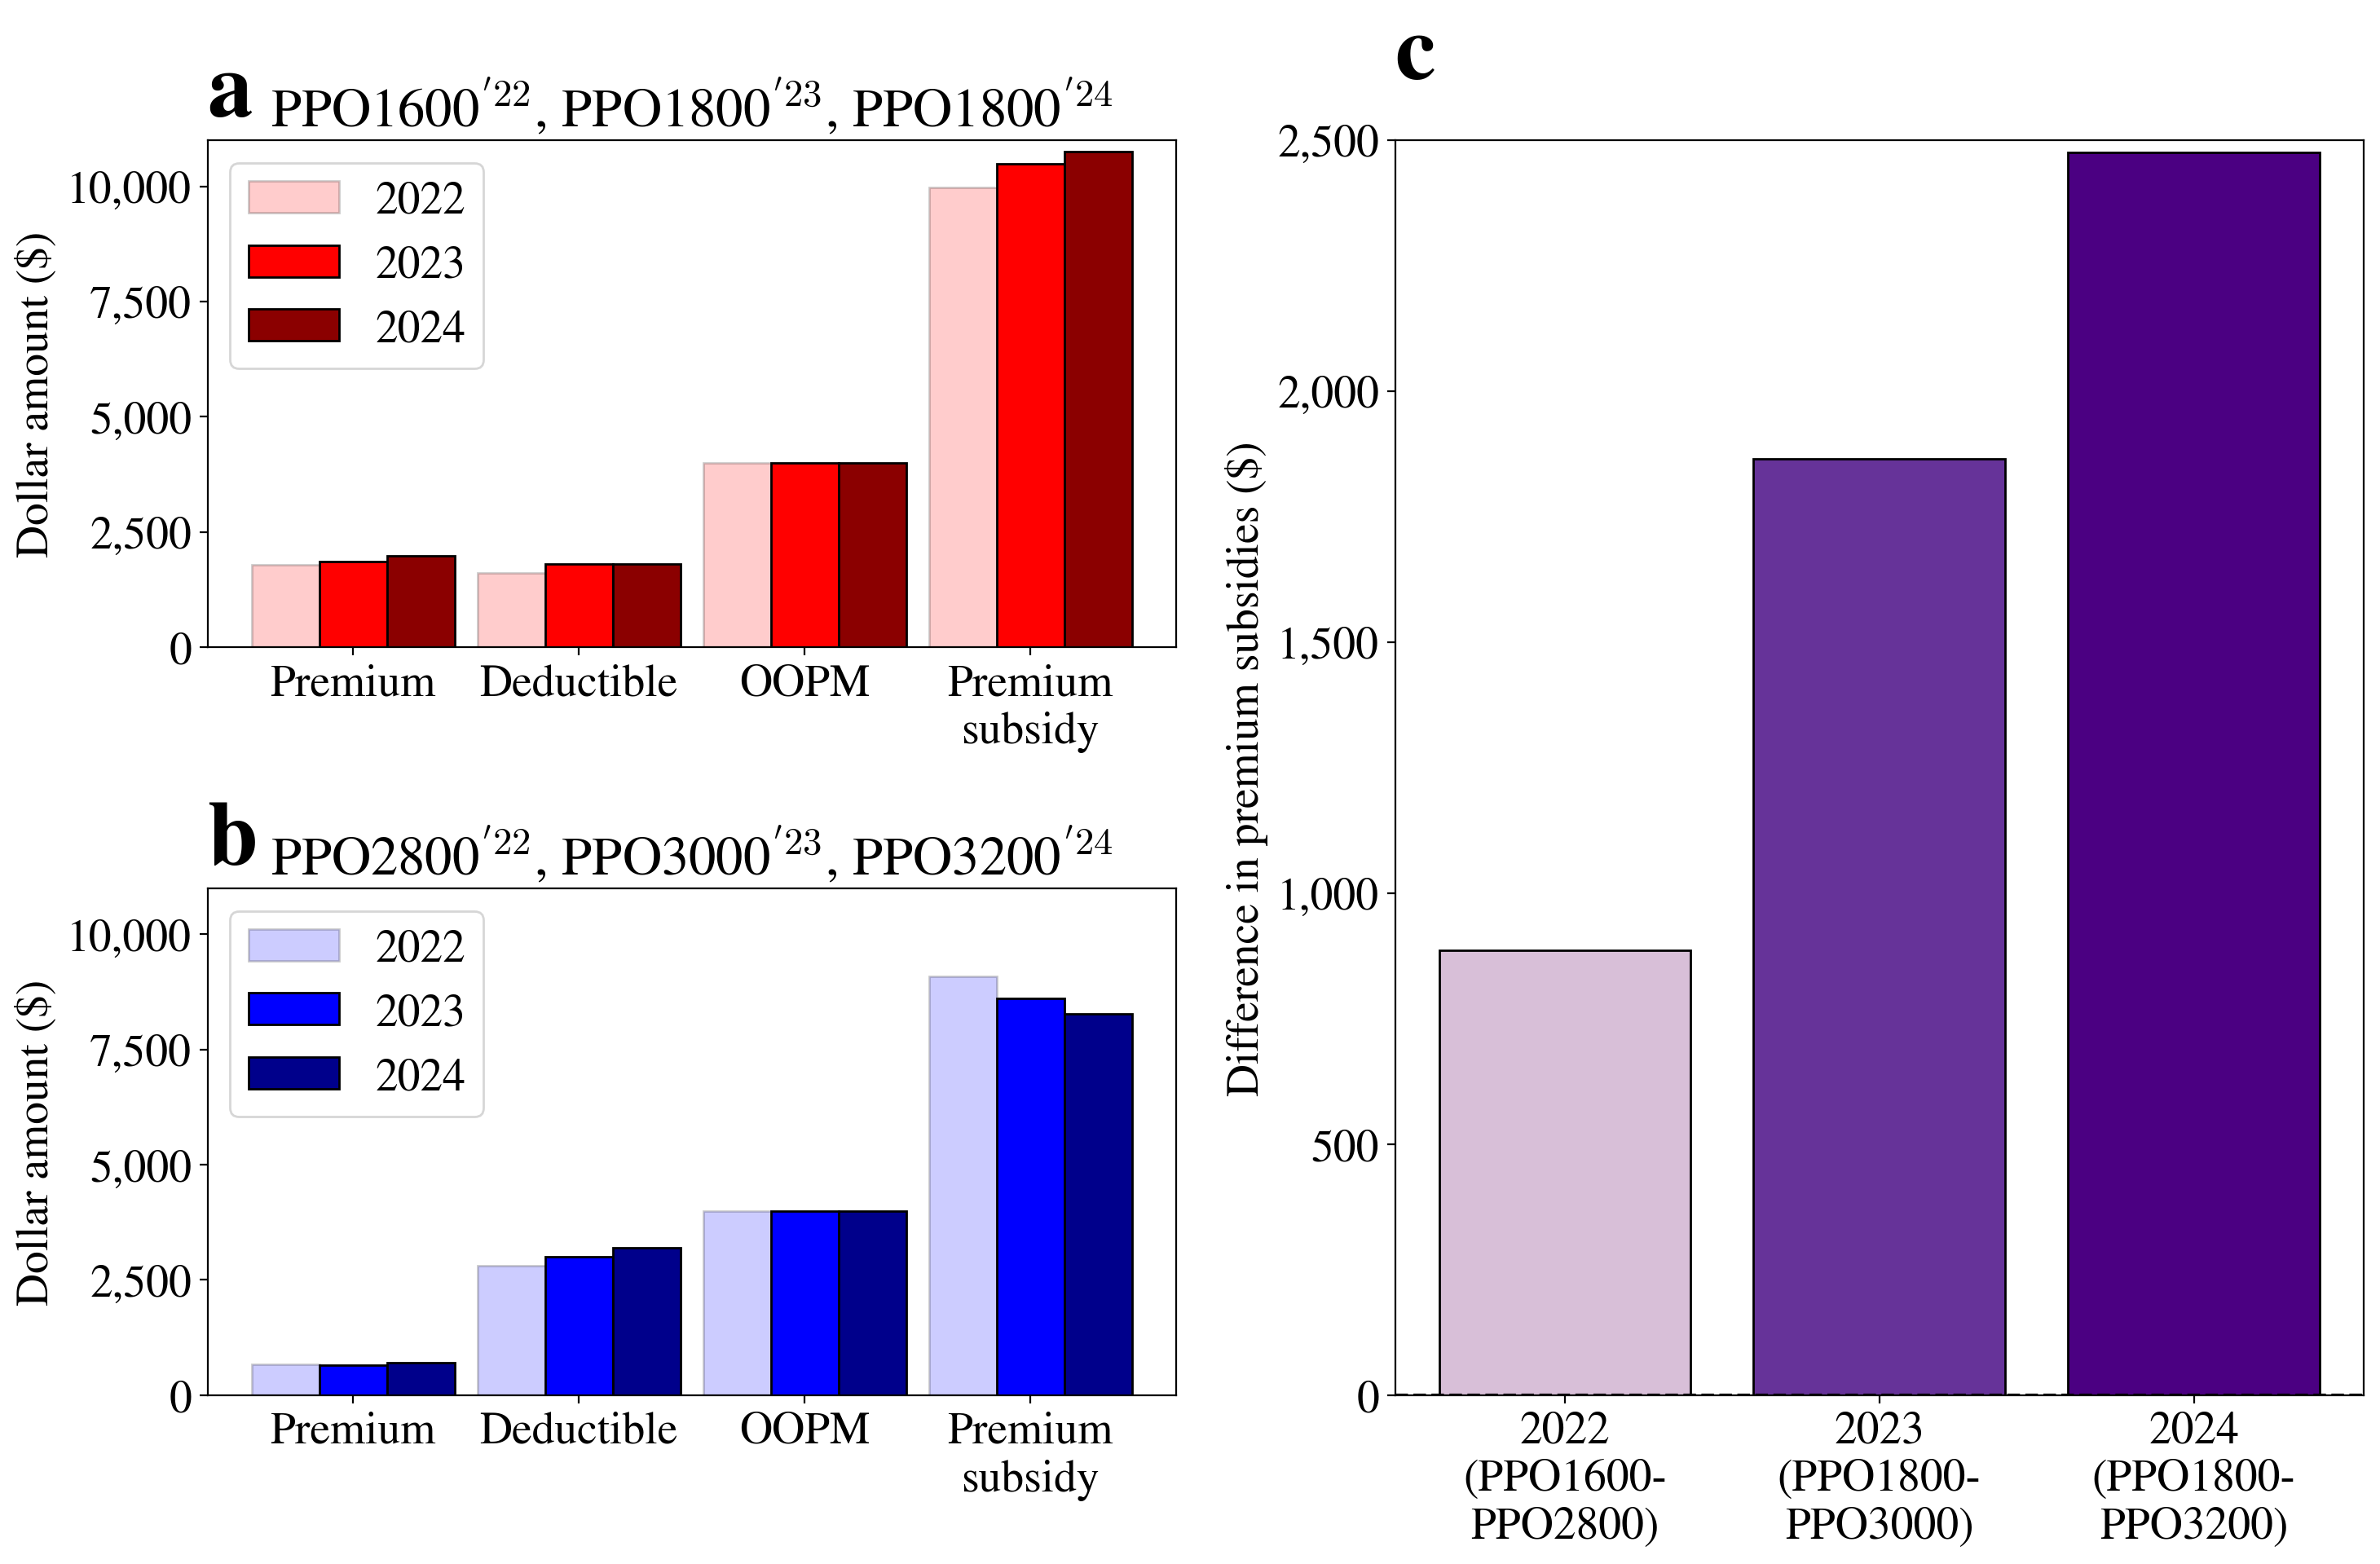

In [99]:
fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

axs = [fig.add_subplot(gs[0, 0]),
       fig.add_subplot(gs[1, 0]),
       fig.add_subplot(gs[:, 1])]

fig.subplots_adjust(hspace=0, wspace=0)

######################################################################################################################################################
ax = axs[0]
plan22 = "PPO1600-22"
premium22, deductible22, oopm22, sub22 = (
    plans[plan22]["premium"],
    plans[plan22]["deductible"],
    plans[plan22]["oopm"],
    plans[plan22]["premium_subsidy"]
)

y22 = [
    premium22, deductible22, oopm22, sub22
]

plan23 = "PPO1800-23"
premium23, deductible23, oopm23, sub23 = (
    plans[plan23]["premium"],
    plans[plan23]["deductible"],
    plans[plan23]["oopm"],
    plans[plan23]["premium_subsidy"]
)
y23 = [
    premium23, deductible23, oopm23, sub23
]

plan24 = "PPO1800-24"
premium24, deductible24, oopm24, sub24 = (
    plans[plan24]["premium"],
    plans[plan24]["deductible"],
    plans[plan24]["oopm"],
    plans[plan24]["premium_subsidy"]
)
y24 = [
    premium24, deductible24, oopm24, sub24
]

labels = ["Premium", "Deductible", "OOPM", "Premium\nsubsidy"]
x = np.arange(len(labels))
width = 0.3

ax.bar(x-width, y22, width=width, label='2022', edgecolor="k", color="red", alpha=0.2)
ax.bar(x, y23, width=width, label='2023', edgecolor="k", color="red")
ax.bar(x+width, y24, width=width, label='2024', edgecolor="k", color="darkred") # New year's data


ax.set(**{
    "xticks": x,
    "xticklabels": labels,
    "title": f"{plan22.split('-')[0]}$^{{'22}}$, {plan23.split('-')[0]}$^{{'23}}$, {plan24.split('-')[0]}$^{{'24}}$",
    "ylim": (0, 11_000),
    "ylabel": "Dollar amount ($)"
    }
)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

##################################################################################
ax = axs[1]

plan22 = "PPO2800-22"
premium22, deductible22, oopm22, sub22 = (
    plans[plan22]["premium"],
    plans[plan22]["deductible"],
    plans[plan22]["oopm"],
    plans[plan22]["premium_subsidy"]
)

y22 = [
    premium22, deductible22, oopm22, sub22
]

plan23 = "PPO3000-23"
premium23, deductible23, oopm23, sub23 = (
    plans[plan23]["premium"],
    plans[plan23]["deductible"],
    plans[plan23]["oopm"],
    plans[plan23]["premium_subsidy"]
)
y23 = [
    premium23, deductible23, oopm23, sub23
]

plan24 = "PPO3200-24"
premium24, deductible24, oopm24, sub24 = (
    plans[plan24]["premium"],
    plans[plan24]["deductible"],
    plans[plan24]["oopm"],
    plans[plan24]["premium_subsidy"]
)
y24 = [
    premium24, deductible24, oopm24, sub24
]

labels = ["Premium", "Deductible", "OOPM", "Premium\nsubsidy"]
x = np.arange(len(labels))
width = 0.3
ax.bar(x-width, y22, width=width, label='2022', edgecolor="k", color="blue", alpha=0.2)
ax.bar(x, y23, width=width, label='2023', edgecolor="k", color="blue")
ax.bar(x+width, y24, width=width, label='2024', edgecolor="k", color="darkblue") # New year's data


ax.set(**{
    "xticks": x,
    "xticklabels": labels,
    "ylim": (0, 11_000),
    "ylabel": "Dollar amount ($)",
    "title": f"{plan22.split('-')[0]}$^{{'22}}$, {plan23.split('-')[0]}$^{{'23}}$, {plan24.split('-')[0]}$^{{'24}}$",
    }
)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

ax = axs[2]

labels = [
    "2022\n(PPO1600-\nPPO2800)",
    "2023\n(PPO1800-\nPPO3000)",
    "2024\n(PPO1800-\nPPO3200)"
]
y = [
    plans["PPO1600-22"]["premium_subsidy"] - plans["PPO2800-22"]["premium_subsidy"],
    plans["PPO1800-23"]["premium_subsidy"] - plans["PPO3000-23"]["premium_subsidy"],
    plans["PPO1800-24"]["premium_subsidy"] - plans["PPO3200-24"]["premium_subsidy"],
]
ax.bar(labels, y, edgecolor="k", color=["thistle", "rebeccapurple", "indigo"])
ax.axhline(0, color="k", linestyle="--")
ax.set(**{
    "ylabel": "Difference in premium subsidies ($)",
    "ylim": (0, 2500)
})

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for n, ax in enumerate(axs):

    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes,
            size=40, weight='bold')

# fig.savefig("yoy-costs.png", dpi=300, bbox_inches="tight")
fig.show()